In [1]:
%matplotlib inline
import json 
import matplotlib.pyplot as plt
import os
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import keras 

# import numpy
# import pandas
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
import tensorflow as tf


from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence

import glob

from sklearn.model_selection import train_test_split
from sklearn.metrics import multilabel_confusion_matrix


from keras import backend as K

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction.text import CountVectorizer

# import os
# os.environ['KMP_DUPLICATE_LIB_OK']='True'
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.multiclass import OneVsRestClassifier
from xgboost import plot_tree
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction.text import CountVectorizer

Using TensorFlow backend.


# Main configs

In [2]:
loadFromMerged=True
loadFromIndexes= False
Mapper='SE'
IgnoreEmpty= True
FoldID ="1"
Epoch_count=100
Batch_size=5000
INCLUDE_DIRECTION = True

LOAD_OLD_DATA_TRAIN = False
LOAD_OLD_DATA_TEST = False
MERGE_TESTS=True

TEST_CLASS_CAP =150

# Load the data the old way


In [3]:
# x_data= [] 
# y_data= [] 


# with open( '../files/txt/seq_mapping_large.txt' ) as f:
#     x_data =   f.readlines()

# with open( '../files/txt/command_mapping_large.txt' ) as f:
#     y_data = f.readlines()
    
    
# x_data =[ np.array([ int(y) for y in x.strip().split( ' ') ])   for x in  x_data ] 
# y_data =[ x.strip().split(' ') for x in  y_data ] 


#  Load The Data The New Way

In [4]:
#  mapps the input records to a integer array for the input
def mapping_x( inp, include_direction = False , TrimAt= 15 ):
    if include_direction:
        return np.array([ int(x["packet_length"]) * (1 if x['packet_source']=='hub' else -1)  for x in inp ][:15])
    else:
        return np.array([ int(x["packet_length"])  for x in inp ][:15])

In [5]:
def mapping_y_service(inp):
    return np.array(  list(set([x["event"] for x in inp])) if (len(inp )>0) else ["none"] )

def mapping_y_service_event(inp):
    return np.array(  list(set([ "%s-%s"%( x["event"] ,x["val"] ) for x in inp])) if (len(inp )>0) else ["none"] )

def mapping_y_device_service(inp):
    return np.array(  list(set([ "%s & %s"%( x["device"] ,x["event"] ) for x in inp])) if (len(inp )>0) else ["none"] )

def mapping_y_full(inp):
    return np.array(  list(set([ "%s & %s & %s"%( x["device"] ,x["event"], x['val'] ) for x in inp])) if (len(inp )>0) else ["none"] )


In [6]:
# this cleans the data removing emply nodes and turning the nodes into sarrays by calling the mapping function 

def clean_data( x_data, y_data , removeempty=True, Mapping='S', include_direction=False):
    cleans = [] 
    cleans = (sorted([ x for x in y_data if (removeempty and len(y_data[x]) > 0) or not removeempty  ] ))
    
    ret_x  = [x_data[x] for x in cleans]
    ret_y  = [y_data[x] for x in cleans] 
    
    print( len(y_data), len(cleans) )
    
    ret_x  = [ mapping_x(x, include_direction=include_direction) for x in ret_x ] 
    ret_y_s = [ mapping_y_service(y) for y in ret_y ]
    if Mapping=='S':
        ret_y  = [ mapping_y_service(y) for y in ret_y ]
    elif Mapping=='SE':
        ret_y  = [ mapping_y_service_event(y) for y in ret_y ]
    elif Mapping=='DS':
        ret_y  = [ mapping_y_device_service(y) for y in ret_y ]
    elif Mapping=='F':
        ret_y  = [ mapping_y_full(y) for y in ret_y ]
    
#     ret_y = ret_y.tolist()
#     ret_y_s = ret_y_s.tolist()
    
#     for t in ret_y:
#         if 'no_logs' in t:
#             t.remove('no_logs')
#             t.append('unknown')
#     ret_y_s.remove('no_logs')
    
#     ret_y = np.array(ret_y)
#     ret_y_s = np.array(ret_y_s)
    
    return ret_x, ret_y, ret_y_s

In [7]:
x= []
y= []

x_test = []
y_test = []
y_test_service= []

x_train = []
y_train = []
y_train_service = []

test_names = []

add_to_trainig = [0,2]

if loadFromMerged:
    print("in load from merged")
    if LOAD_OLD_DATA_TRAIN:
        with open(  '../files/train/test/test_homes/final_upload/Merged_final_with_home/merged_hub_segments_final.json'  ) as f:
            y_data = json.load(f)

        with open(  '../files/train/test/test_homes/final_upload/Merged_final_with_home/merged_pcap_segments_final.json'  ) as f:
            x_data = json.load(f)

    #     with open(  '../files/train/merged/hub_segments_2.json'  ) as f:
    #         y_data = json.load(f)

    #     with open(  '../files/train/merged/pcap_segments_2.json'  ) as f:
    #         x_data = json.load(f)

        if len( y_data ) != len(x_data) :
            print( pick )


        x_train,y_train, y_train_service= clean_data( x_data, y_data, IgnoreEmpty , 
                                                     Mapping=Mapper, include_direction=INCLUDE_DIRECTION )
    else:
        
        for pick in sorted(glob.glob( '../files/iot_data_2020/train/hub_segments/*.json' )):
            fname  = os.path.basename(pick)
#             test_names.append( fname )
            with open( os.path.join( '../files/iot_data_2020/train/hub_segments/', fname) ) as f:
                y_data = json.load(f)

            with open( os.path.join('../files/iot_data_2020/train/pcap_segments/', fname) ) as f:
                x_data = json.load(f)

            if len( y_data ) != len(x_data) :
                print( pick )
                continue

            x_t,y_t, y_t_s= clean_data( x_data, y_data, IgnoreEmpty , 
                                                     Mapping=Mapper, include_direction=INCLUDE_DIRECTION )
    
            x_train.extend(x_t)
            y_train.extend(y_t)
            y_train_service.extend(y_t_s)
            

    #     continue
#     if loadFromIndexes:
#         print("load from indexes")
#         with open("../files/train/merged/items_2_test-train_indexes.json")  as f:
#             index_info = json.load(f)


#         for i in index_info[FoldID]["test"]:
#             x_test[str(i)]=(x_data[str(i)] )
#             y_test[str(i)]=(y_data[str(i)] )

#         for i in index_info[FoldID]["train"]:
#             x_train[str(i)]=(  x_data[str(i)] )
#             y_train[str(i)]=(  y_data[str(i)] )
        
#         x_test_t,y_test_t= clean_data( x_test, y_test, IgnoreEmpty , Mapping=Mapper)
#         x_test.append(x_test_t)
#         y_test.append(y_test_t)
    #     else :
    print("loading from test files")
    files_path =  '../files/train/test/test_homes/final_upload/usecases/pcap_segments_final_final/home*.json' if LOAD_OLD_DATA_TEST else '../files/iot_data_2020/usecases/pcap_segments_final/*.json'
    test_y_dir = '../files/train/test/test_homes/final_upload/usecases/hub_segments_final_final/' if LOAD_OLD_DATA_TEST else '../files/iot_data_2020/usecases/hub_segments_final/'
    test_x_dir = '../files/train/test/test_homes/final_upload/usecases/pcap_segments_final_final/' if LOAD_OLD_DATA_TEST else '../files/iot_data_2020/usecases/pcap_segments_final/'
    
    test_files = sorted(glob.glob(files_path))
    print( "found files : " , len(test_files) )
    
    
    for pick  in test_files:
        fname  = os.path.basename(pick)
        test_names.append( fname )
        print(fname)
        with open( os.path.join(test_y_dir , fname) ) as f:
            y_data_test = json.load(f)

        with open( os.path.join(test_x_dir, fname) ) as f:
            x_data_test = json.load(f)


        t_x,t_y, t_z= clean_data( x_data_test, y_data_test, False , Mapping=Mapper, include_direction= INCLUDE_DIRECTION )

#         if test_files.index(pick) in add_to_trainig:
#             x_test_t,y_test_t, y_test_service_t= clean_data( x_data_test, y_data_test, IgnoreEmpty , Mapping=Mapper)
#             x_train.extend(x_test_t)
#             y_train.extend(y_test_t)
#             y_train_service.extend(y_test_service_t)

                
        if MERGE_TESTS:
            x_test.extend(t_x)
            y_test.extend(t_y)
            y_test_service.extend(t_z)
        else:
            x_test.append(t_x)
            y_test.append(t_y)
            y_test_service.append(t_z)
if MERGE_TESTS:
    x_test = [x_test]
    y_test = [y_test]
    y_test_service = [y_test_service]
    test_names =['MERGED']
#     x_test = x_data[ index_info["1"]["test"]  ]
#     y_test = y_data[ index_info["1"]["test"]  ]
    
#     x_train = x_data[ index_info["1"]["train"]  ]
#     y_train = y_data[ index_info["1"]["train"]  ]
#     x.extend(t_x)
#     y.extend(t_y)
else:
    for pick in sorted(glob.glob( '../files/train/hub_segments/*.json' )):
        fname  = os.path.basename(pick)
        test_names.append( fname )
        with open( os.path.join( '../files/train/hub_segments/', fname) ) as f:
            y_data = json.load(f)

        with open( os.path.join('../files/train/pcap_segments/', fname) ) as f:
            x_data = json.load(f)

        if len( y_data ) != len(x_data) :
            print( pick )
            continue

        t_x,t_y= clean_data( x_data, y_data, True, include_direction=INCLUDE_DIRECTION )

        x.extend( t_x)
        y.extend(t_y)

x= np.array(x)
y= np.array(y)

# x_train = np.append( x_train, x_test[0] , axis=0)
# x_train = np.append( x_train, x_test[2] , axis=0)

# y_train = np.append( y_train, y_test[0] , axis=0)
# y_train = np.append( y_train, y_test[2] , axis=0)


len(x_train), len(y_test)

in load from merged
2522 2335
0 0
7 6
0 0
9 9
3161 3047
2703 2229
17 17
29 17
2960 2778
1775 1697
15 12
191 143
0 0
10 9
7114 6606
983 652
918 890
1703 1540
7 7
2199 2179
loading from test files
found files :  5
home_os_final.json
18308 18308
home_sk_final.json
5837 5837
test_data_light.json
233 233
test_data_lock.json
807 807
test_data_motion_2.json
8133 8133


(24173, 1)

# Evaluate Mittigation Techniques

## Packet Padding

In [8]:
# days =[7,4,2,2]
# t_sum =0
# for ii in range(len(x_test)):
#     p = x_test[ii]
#     sizes = np.unique(np.concatenate(p), return_counts=True)
#     sums= 0 
#     for i in range(len(sizes[0])):
# #         print( "%d--> %d" % ( sizes[0][i], sizes[1][i] ) )
#         if  sizes[0][i] < 1000:
#             sums+= (1000-sizes[0][i] )* sizes[1][i]
#     t_sum +=(sums / days[ii] )/1000000 
#     print ( (sums / days[ii] )/1000000)
# print('--------')
# print(t_sum/4)    

In [9]:
# days =[7,4,2,2]
# t_sum =0
# d_sum = 0
# import math
# for ii in range(len(x_test)):

#     p = x_test[ii]
#     for i in p : 
#         t_sum += math.ceil(np.sum(i) / 2000)
#         d_sum+= np.sum( i )
# total_fixed  =  t_sum* 2000 / 15

# print ( total_fixed , d_sum, d_sum-t_sum*2000)

## Packet Insertion

In [10]:
# days =[7,4,2,2]
# t_sum =0
# for ii in range(len(x_test)):
#     p = x_test[ii]
#     sizes = np.unique(np.concatenate(p), return_counts=True)
#     sums= 0 
#     for i in range(len(sizes[0])):
# #         print( "%d--> %d" % ( sizes[0][i], sizes[1][i] ) )
#         if  sizes[0][i] < 1000:
#             sums+= (1000-sizes[0][i] )* sizes[1][i]
#     t_sum +=(sums / days[ii] )/1000000 
#     print ( (sums / days[ii] )/1000000)
# print('--------')
# print(t_sum/4)    

# sets the classes 

In [11]:
classes = sorted(list(np.unique(  np.concatenate( y_train  ))))
# print([ (i , classes[i]) for i in range( len(classes) ) ])

service_classes = sorted(list(np.unique(  np.concatenate( y_train_service  ))))
[ (i , service_classes[i]) for i in range( len(service_classes) ) ]

[(0, 'acceleration'),
 (1, 'activity'),
 (2, 'battery'),
 (3, 'button'),
 (4, 'colorTemperature'),
 (5, 'contact'),
 (6, 'level'),
 (7, 'lock'),
 (8, 'motion'),
 (9, 'no_logs'),
 (10, 'ping'),
 (11, 'status'),
 (12, 'switch'),
 (13, 'temperature'),
 (14, 'threeAxis'),
 (15, 'unknown'),
 (16, 'water')]

In [12]:
classes

['acceleration-active',
 'acceleration-inactive',
 'activity-hubDisconnected',
 'activity-offline',
 'activity-online',
 'battery-XXX',
 'button-held',
 'button-pushed',
 'colorTemperature-XXX',
 'contact-closed',
 'contact-open',
 'level-XXX',
 'lock-locked',
 'lock-unlocked',
 'motion-active',
 'motion-inactive',
 'no_logs-',
 'ping-ping',
 'status-closed',
 'status-open',
 'switch-off',
 'switch-on',
 'temperature-XXX',
 'threeAxis-XXX',
 'unknown-',
 'water-dry',
 'water-wet']

## Filter the records by service/event types

In [13]:
def is_clean_event( inp, return_clean= True  ):
    return is_clean(inp, return_clean=return_clean, to_keep=[ 'no_logs', 'lock-unlocked', 'on/off-XXX', 'raw-XXX', 'read_attr_-_raw-XXX' ] )
#     if return_clean:
#         return  'no_logs' not in inp and 'lock-unlocked' not in inp and 'on/off-XXX' not in inp and 'raw-XXX' not in inp and 'read_attr_-_raw-XXX' not in inp
#     else:
#         return  'lock-locked' in inp or 'lock-unlocked'  in inp or 'on/off-XXX' in inp or  'raw-XXX' in inp  or 'read_attr_-_raw-XXX' in inp 
     
def is_clean_service( inp, return_clean= True  ):
    return is_clean(inp, to_keep=['no_logs','unknown', 'read_attr_-_raw'], return_clean=return_clean )
    
#     if return_clean:
#         return  'no_logs' not in inp and 'unknown' not in inp and 'read_attr_-_raw' not in inp #and 'ping' not in inp 
#     else:
#         return  'no_logs' in inp or  'unknown' in inp  or 'read_attr_-_raw' in inp #or 'ping' in inp 

def is_clean(inp, to_keep=[], return_clean=True):
    ret = False 
    
    for x  in to_keep:
        if x in inp:
            ret = True
            
    if not return_clean:
        ret = not ret
        
    return ret
    

choose services to keep : 

In [14]:
if Mapper=='SE':
    services_to_keep = [
        "colorTemperature-XXX",
"contact-closed",
"contact-open",
"level-XXX",
"lock-locked",
"lock-unlocked",
"motion-active",
"motion-inactive",
"ping-ping",
"status-closed",
"status-open",
"switch-off",
"switch-on",
"temperature-XXX"
    ]
#     services_to_keep = [x for x in classes if x  not in ['unknown-','no_logs-',"acceleration-active", 'acceleration-inactive','activity-hubDisconnected',
#  'activity-offline',
#  'activity-online',
#  'battery-XXX',] ]#[ 'contact', 'lock', 'motion',"ping", 'switch','unknown'] 
else:
     services_to_keep =["button",
"colorTemperature",
"contact",
"level",
"lock",
"motion",
"ping",
"status",
"switch",
"temperature"]
#     services_to_keep = [x for x in classes if x  not in ['no_logs',"acceleration","activity","battery"] ]#[ 'contact', 'lock', 'motion',"ping", 'switch','unknown'] 

find records which need change

In [15]:
train_indexes_to_change =  [ i for i in range(len(y_train)) if
              is_clean( y_train[i],to_keep=services_to_keep, return_clean=False) ] 

y_train = [ ['unknown'] if i in train_indexes_to_change else y_train[i] 
           for i in range(len(y_train)) ] 

for t_index in range(len(y_test)):
    test_indexes_to_change =  [ i for i in range(len(y_test[t_index])) if
                  is_clean( y_test[t_index][i],to_keep=services_to_keep, return_clean=False) ] 

    y_test[t_index] = [ ['unknown'] if i in test_indexes_to_change else y_test[t_index][i] 
               for i in range(len(y_test[t_index])) ] 

In [16]:
def make_known_unknown(inp, unknown_ind):
    return [ [1,0] if (x[unknown_ind] == 1 ) else [0,1]   for x in inp ]

known_unknown_y_train = [ [1,0] if (len(x) == 1 and ("unknown" in x or 'unknown-' in x)) else [0,1]   for x in y_train ]

known_unknown_y_test= [] 

for i in range(len(y_test)):
    
    known_unknown_y_test.append( [ [1,0] if (len(x) == 1 and "unknown" in x) else [0,1]   for x in y_test[i] ])


remove classes that are ignored from the services list 

In [17]:
len(x_train),len(y_train),len(known_unknown_y_train), len(y_test[0]), len(known_unknown_y_test[0])

(24173, 24173, 24173, 33318, 33318)

In [18]:
classes = services_to_keep
classes.append('unknown')
classes

['colorTemperature-XXX',
 'contact-closed',
 'contact-open',
 'level-XXX',
 'lock-locked',
 'lock-unlocked',
 'motion-active',
 'motion-inactive',
 'ping-ping',
 'status-closed',
 'status-open',
 'switch-off',
 'switch-on',
 'temperature-XXX',
 'unknown']

In [19]:
# toKeep = [ i for i in range(len(y_train)) if is_clean_event( y_train[i]) ] if Mapper=='SE' else [ i for i in range(len(y_train)) if is_clean_service( y_train[i]) ]
# x_train= [ x_train[i] for i in toKeep ]
# y_train= [ y_train[i] for i in toKeep ]


In [20]:
# for j in range(len(x_test)):
#     toChange= [ i for i in range(len(y_test[j])) if is_clean_service( y_test[j][i], False) ]
#     y_test[j] = [ (y_test[j][i] if i not in toChange else np.array( ['none'])) for i in range(len(y_test[j])) ]

In [21]:
# classes.remove('read_attr_-_raw-XXX')
# classes.remove('on/off-XXX')
# classes.remove('raw-XXX')
# classes.remove('lock-unlocked')
# classes.remove('lock-locked')


# classes.remove('read_attr_-_raw')
# classes.remove('on/off')
# classes.remove('raw')
# classes.remove('unknown')

# classes.remove('lock')
# # classes.remove('lock')


# classes.remove('switch-on')




## ===== end of unknown packet control=====

In [22]:
def pre_process_raw( x_data,y_data, dim_size = 128, zero_pad = False, normalize = False ,
                    classes=None, twoD= False, as_string=False, class_cap = 9999999, cheat=True ):
#  y data 
# """
# this functino is in charge of preprocessing the records , the sourc e json contains a lot of extra stuff, this function tailors
# the data and it fixes their lenghth
# """
    if classes is None:
        classes  = sorted(list(np.unique( np.concatenate( y_data  ))))
    else :
        classes = sorted(classes)
    y_data_categorical = []  

    to_keep_indexes = []
    class_counts= {x:0 for x in classes}
    for pick in ['ping','ping-ping','unknown']:
        if pick in class_counts:
            class_counts[pick] = -9999999

    for i,x in enumerate(y_data):
        temp = np.zeros(len(classes))
        x= list(set(x))
        for y in x: 
            
            if cheat and (y=='unknown' or y=='unknown-') and len(x)>1:
                    continue
                    
            if y in classes:
                if class_counts[y] < class_cap:
                    temp[classes.index(y)] = 1
                    class_counts[y] += 1
                    
        if np.sum(temp) > 0 :    
            y_data_categorical.append(temp)
            to_keep_indexes.append(i)
    y_data_categorical = np.vstack(y_data_categorical)
    
#     x_data = np.array( x_data) / 1500.0
    
    x_data_temp = [] 
    
    if not zero_pad:
        if twoD:
            for i,x in enumerate( x_data):
                if i not in to_keep_indexes:
                    continue
                    
                temp = [] #list(x)
                lst = list(x)
                while dim_size**2 - len(temp )   > len(lst):
                    temp.extend(lst)

                while len(temp) < dim_size**2:
                    temp.append( 0 )

                x_data_temp.append(np.array(temp).reshape(dim_size,dim_size))


            x_data_temp = np.array( x_data_temp )
            x_data_temp=x_data_temp.reshape(x_data_temp.shape+(1,))
        else: 
            temp = [] 
            lst = list(x)
            for i,x in enumerate( x_data):
                if i not in to_keep_indexes:
                    continue
                temp = [] #list(x)
                lst = list(x)
                while dim_size - len(temp )   > len(lst):
                    temp.extend(lst)

                while len(temp) < dim_size:
                    temp.append( 0 )
                
                x_data_temp.append(np.array( temp))
            
    else :
        x_data_temp = sequence.pad_sequences(x_data, maxlen=dim_size)
    
    
    
    if normalize:
        x_data_temp = np.array( x_data_temp) / (np.amax( x_data_temp) + 0.000000000001)
    else :
        x_data_temp = np.array(x_data_temp)
    
    
    if as_string:
        x_data_temp = [ ' '.join(list(map(str,x))) for x in x_data_temp ]
    
    return x_data_temp ,y_data_categorical , classes

In [23]:
x,y,_=pre_process_raw( x_train, y_train , 15, zero_pad=True, normalize=True, classes=classes)

In [24]:
for x in y_train:
    if len(x) ==0 :
        print("*")

# Model Evaluation Methods

In [25]:
def make_recall_shit( inp ):
    tp = inp[1][1]
    tn = inp[0][0]
    fp = inp[0][1] 
    fn = inp[1][0]
    
    acc = (tp+tn)*1.0 / ( tp+tn+fp+fn)*1.0
    recall = tp*1.0/ ( tp+fn ) *1.0
    prec = tp*1.0 / ( tp+fp )*1.0
    
#     F= 2.0*( prec* recall )/ (prec+recall)
    F= 2.0*( tp)/ (2*tp + fp + fn)
    
    return acc, recall, prec, F

def acc_match( true, pred ):
    """
    returns exact mathc accuracy
    """
 
    return (len( [ x  for x  in  [np.sum(np.abs( true[i]- pred[i] )) for i in range(len(true))] if x  == 0]))*1.0 / len(true)


# def acc_none_zero ( true, pred ):
    

def acc_match_wierd( true, pred ):
    """
    returns exact mathc accuracy
    """
    level = 6 
    switch = 11
    threeAxis=13
    accel = 0 
    status=10
    contact=5
    
    counter  = 0 
    for i in range( len (true) ):
        if np.sum(np.abs( true[i]- pred[i] ))==0 :
            counter+=1
        else : 
            t_rec = np.array(list( pred[i]))
            
            if true[i][level]==1 and true[i][switch]==1 and t_rec[level]==1 :
                t_rec[switch]=1
            
            if true[i][threeAxis]==1 and true[i][accel]==1 and t_rec[threeAxis]==1:
                t_rec[accel] =1
            
            if true[i][status]==1 and true[i][contact]==1 and t_rec[status]==1:
                t_rec[contact]=1
#             print(t_rec , true[i])    
            if np.sum(np.abs( true[i]- t_rec ))==0 :
                counter+=1   
            
             
            
    
    return counter*1.0 / len(true)


def print_info(y_test, pred , classes , confidance=0.5, print_skf1=False):
    
    counts = np.sum( y_test.astype(int) , axis=0)
    
    pred[pred>=confidance] = 1
    pred[pred<confidance] = 0
    
#     acc_wierd  =acc_match_wierd(y_test, pred)
    
    conf= multilabel_confusion_matrix( y_test , pred.astype(int), labels= range(len(classes)))
    accs = [make_recall_shit(x) for x in conf]
    print( "%30s  %8s   %8s  %8s  %8s %8s %22s"  %( "Class","Accuracy", "Recall","Precision","F Score" , "Count", "TP/TN/FP/FN"))
    print( "------------------------------------------------------------------------" )
    ret  = [] 
    ret_description = ["Class","Accuracy", "Recall","Precision","F Score" , "Count", "TP","TN","FP","FN"]
    for index in range(len(classes)):
        tp = conf[index][1][1]
        tn = conf[index][0][0]
        fp = conf[index][0][1] 
        fn = conf[index][1][0]
        item = (classes[index],
              accs[index][0],
              accs[index][1],
              accs[index][2],
              accs[index][3],
              counts[index],
                  tp ,
                tn ,
                fp ,
                fn)
        print( "%30s  %8.3f   %8.3f  %8.3f  %8.3f  %8d %5d/%5d/%5d/%5d"  %  item )
        ret.append(item)
        
    n_zeros_true = len([ x  for x  in  [np.sum(np.abs( y_test[i] )) for i in range(len(y_test))] if x  == 0]  )
    n_zeros_pred = len([ x  for x  in  [np.sum(np.abs( pred[i] )) for i in range(len(pred))] if x  == 0]  )
    
    accs = np.nan_to_num(accs)
    
    print ("------------------------------------------------------------------------")
    print( "%30s  %8.3f   %8.3f  %8.3f  %8.3f  %8d %5d/%5d/%5d/%5d"  %
             ("AVERAGES",
              np.average( accs, axis=0)[0],
              np.average( accs, axis=0)[1],
              np.average( accs, axis=0)[2],
              np.average( accs, axis=0)[3],
              len(y_test),
                  0 ,
                0,
                0 ,
                0 ))
    print ("------------------------------------------------------------------------")
    print( "%30s  %8.3f   %8.3f  %8.3f  %8.3f  %8d %5d/%5d/%5d/%5d"  %
             ("Weighted AVERAGES",
              np.average( accs, weights=counts, axis=0)[0],
              np.average( accs, weights=counts, axis=0)[1],
              np.average( accs, weights=counts, axis=0)[2],
              np.average( accs, weights=counts, axis=0)[3],
              len(y_test),
                  0 ,
                0,
                0 ,
                0 ))
    
    print ("------------------------------------------------------------------------")
    unknonw_index = [classes.index('unknown')]
#     print(unknonw_index, len(accs))
    accs_new = np.delete(accs,unknonw_index,0)
    counts_new = [x for i,x in enumerate(counts) if i not in unknonw_index]
#     print(unknonw_index, len(counts), len(counts_new),len(accs), len(accs_new))
#     print(unknonw_index, len(accs))
    print( "%30s  %8.3f   %8.3f  %8.3f  %8.3f  %8d %5d/%5d/%5d/%5d"  %
             ("known Weighted AVERAGES",
              np.average( accs_new, weights=counts_new, axis=0)[0],
              np.average( accs_new, weights=counts_new, axis=0)[1],
              np.average( accs_new, weights=counts_new, axis=0)[2],
              np.average( accs_new, weights=counts_new, axis=0)[3],
              len(y_test),
                  0 ,
                0,
                0 ,
                0 ))
    
    print ("------------------------------------------------------------------------")
    if 'ping' in classes:
        unknonw_index = [classes.index('unknown'), classes.index('ping')]
    #     print(unknonw_index, len(accs))
        accs_new = np.delete(accs,unknonw_index,0)
        counts_new = [x for i,x in enumerate(counts) if i not in unknonw_index]
    #     print(unknonw_index, len(counts), len(counts_new),len(accs), len(accs_new))
    #     print(unknonw_index, len(accs))
        print( "%30s  %8.3f   %8.3f  %8.3f  %8.3f  %8d %5d/%5d/%5d/%5d"  %
                 ("known -ping Weighted AVERAGES",
                  np.average( accs_new, weights=counts_new, axis=0)[0],
                  np.average( accs_new, weights=counts_new, axis=0)[1],
                  np.average( accs_new, weights=counts_new, axis=0)[2],
                  np.average( accs_new, weights=counts_new, axis=0)[3],
                  len(y_test),
                      0 ,
                    0,
                    0 ,
                    0 ))

    print ("------------------------------------------------------------------------")
    unknonw_index = classes.index('unknown')
#     print(unknonw_index, len(accs))
    to_delete = [i for i,x in enumerate(counts) if x == 0 ]
    accs_new = np.delete(accs,to_delete,0)
    counts_new = [x for i,x in enumerate(counts) if i not in  to_delete]
#     print(unknonw_index, len(counts), len(counts_new),len(accs), len(accs_new))
#     print(unknonw_index, len(accs))
    print( "%30s  %8.3f   %8.3f  %8.3f  %8.3f  %8d %5d/%5d/%5d/%5d"  %
             ("non zero count AVERAGES",
              np.average( accs_new, axis=0)[0],
              np.average( accs_new, axis=0)[1],
              np.average( accs_new, axis=0)[2],
              np.average( accs_new, axis=0)[3],
              len(y_test),
                  0 ,
                0,
                0 ,
                0 ))
    
    print ("------------------------------------------------------------------------")
    from sklearn.metrics import f1_score
    f1 = f1_score(y_test, pred, average='macro')
    print("Macro F1 : %f" % f1)
    f1 = f1_score(y_test, pred, average='samples')
    print("sample F1 : %f" % f1)
    f1 = f1_score(y_test, pred, average='weighted')
    print("weighted F1 : %f" % f1)

    
    if 'ping' in classes and print_skf1:
        unknonw_index = classes.index('unknown')
        ping_index = classes.index('ping')
        print ("--------------------------removed ping and unknown----------------------------------------------")
        to_remove_indexes = [i for i,x in enumerate(pred) if x[ping_index]+x[unknonw_index] > 0.5]
        new_pred   =np.array( [x for i,x  in enumerate(pred) if i not in to_remove_indexes ])
        new_y_test = np.array([x for i,x  in enumerate(y_test) if i not in to_remove_indexes ])
        f1 = f1_score(new_y_test, new_pred, average='macro')
        print("Macro F1 : %f" % f1)
        f1 = f1_score(new_y_test, new_pred, average='samples')
        print("sample F1 : %f" % f1)
        f1 = f1_score(new_y_test, new_pred, average='weighted')
        print("weighted F1 : %f" % f1)

    
    
    print ( "Exact Match ACC : %.5f " % acc_match( y_test, pred )  )
#     print ( "Wierd Exact Match ACC : %.5f" % acc_wierd)
    print ( "Total Records : %d " % len(y_test)  )
    print ( "Total ZXeros in True : %d (%.3f)%%" % (n_zeros_true ,  n_zeros_true * 1.0/ len(y_test)  ))
    print ( "Total ZXeros in Test : %d (%.3f)%%" % (n_zeros_pred ,  n_zeros_pred * 1.0/ len(y_test)  ) )
    print ('=============================================================================')
    
    return ret, ret_description
    

In [26]:
def make_readable_results ( inp , classes , conffidance=True):
    ret = [] 
    inp =inp.astype(int)
    for xx in range(len(inp)) :
        u = inp[xx]
        temp = []
        for j in range(len(u)) : 
            if u[j] >0:
                temp.append(classes[j])
        ret.append(temp)
    return ret


def makeReadable( model , data, gt, path , classes, x, confidance=0.5):
    #collect across multi models
    from keras.models import load_model
    x=[]
    for i in range(0,16):
        model=load_model('number'+str(i)+'.h5',custom_objects={'f1_perRow':f1_perRow,'f1_perClass':f1_perClass,'f1_loss_perRow':f1_loss_perRow,'f1_loss_perClass':f1_loss_perClass})
        x.append(model.predict(data))
    x=np.array(x)
    x=np.transpose(x)
    x=np.squeeze(x)
    print(x.shape)
        
        
    pred_temp  = x
    #pred_temp = model.predict(data)
    print_info(gt, x, classes , confidance=confidance)


In [27]:
def add_unknowns_back(y_pred, original_y, indexes, classes):
    unknown = [1 if classes[i] == 'unknown' else
                        0  
                       for i in range(len(classes))]
    the_y = [unknown for i in range(len(original_y))]
    for i, v in enumerate(indexes):
#         print(v)
        the_y[v] = y_pred[i]
    return np.array(the_y)

get the data and preprocess train and test portions

In [28]:
dim_size= 20
x_random_forest_train,y_random_forest_train, _ = pre_process_raw( x_train, y_train , dim_size, zero_pad=False, normalize=False, classes=classes, as_string=True)
rf_tests  = [ pre_process_raw( x_test[i], y_test[i] , dim_size, zero_pad=False, normalize=False, classes=classes, as_string=True, class_cap=TEST_CLASS_CAP) for i in range(len(x_test)) ] 

In [29]:
len(x_train),len(x_random_forest_train), len(y_random_forest_train)

(24173, 24173, 24173)

vectorize the X vars

In [30]:
vectorizer = CountVectorizer(analyzer='word', ngram_range=(1, 5))
x_random_forest_train = vectorizer.fit_transform(x_random_forest_train)
for x in range(len(rf_tests)):
    rf_tests[x] = ( vectorizer.transform(rf_tests[x][0]),
                    rf_tests[x][1],
                    rf_tests[x][2]
                  )
    

# XGBoost 

In [31]:
len(known_unknown_y_train), len(x_random_forest_train.toarray())

(24173, 24173)

In [32]:

xgb_known_unknown_separator_classifier = OneVsRestClassifier(XGBClassifier())

xgb_known_unknown_separator_classifier.fit(x_random_forest_train, np.array(known_unknown_y_train))

train_known_unknown_pred=xgb_known_unknown_separator_classifier.predict_proba(x_random_forest_train)


In [33]:
len(rf_tests[0][1]),len(rf_tests[0][0].toarray()), len(known_unknown_y_test[i])

(31504, 31504, 33318)

In [34]:
test_known_unknown_predicted = []
for i in range(len(rf_tests)) :
    print( "==================HOME Case : %s =============" % test_names[ i] )
    rf_pred=xgb_known_unknown_separator_classifier.predict( rf_tests[i][0])
    test_known_unknown_predicted.append(rf_pred)
    print_info( np.array( make_known_unknown(rf_tests[i][1], classes.index('unknown'))), rf_pred, ["unknown","known"])

==================HOME Case : MERGED =============
                         Class  Accuracy     Recall  Precision   F Score    Count            TP/TN/FP/FN
------------------------------------------------------------------------
                       unknown     0.779      0.675     0.979     0.799     20483 13822/10722/  299/ 6661
                         known     0.779      0.973     0.617     0.755     11021 10722/13822/ 6661/  299
------------------------------------------------------------------------
                      AVERAGES     0.779      0.824     0.798     0.777     31504     0/    0/    0/    0
------------------------------------------------------------------------
             Weighted AVERAGES     0.779      0.779     0.852     0.784     31504     0/    0/    0/    0
------------------------------------------------------------------------
       known Weighted AVERAGES     0.779      0.973     0.617     0.755     31504     0/    0/    0/    0
----------------------

In [35]:
known_indexes_train  = [ i for i in range(len(train_known_unknown_pred)) if train_known_unknown_pred[i][1] ==1 ]

x_train_known = x_random_forest_train[known_indexes_train]
y_train_known = y_random_forest_train[known_indexes_train]

rf_test_known = [] 

for test_index in range(len(test_known_unknown_predicted)):
    known_indexes= [ i for i in range(len(test_known_unknown_predicted[test_index])) if test_known_unknown_predicted[test_index][i][1] ==1 ]
    
    rf_test_known.append(  (rf_tests[test_index][0][known_indexes], 
                            rf_tests[test_index][1][known_indexes],
                            rf_tests[test_index][2],
                            known_indexes
                           ))

In [36]:
xgb_classifier = OneVsRestClassifier(XGBClassifier())

xgb_classifier.fit(x_random_forest_train, np.array(y_random_forest_train))


OneVsRestClassifier(estimator=XGBClassifier(base_score=None, booster=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, gamma=None,
                                            gpu_id=None, importance_type='gain',
                                            interaction_constraints=None,
                                            learning_rate=None,
                                            max_delta_step=None, max_depth=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            n_estimators=100, n_jobs=None,
                                            num_parallel_tree=None,
                                            objective='binary:logistic',
                                            

In [37]:
xg_boost_results = []
for i in range(len(rf_test_known)) :
    print( "==================HOME Case : %s =============" % test_names[ i] )
    rf_pred= xgb_classifier.predict( rf_test_known[i][0])
    rf_pred = add_unknowns_back(rf_pred,rf_tests[i][1], rf_test_known[i][3] , classes)
    xg_boost_results.append(print_info( rf_tests[i][1], rf_pred, classes, confidance=0.8))

==================HOME Case : MERGED =============
                         Class  Accuracy     Recall  Precision   F Score    Count            TP/TN/FP/FN
------------------------------------------------------------------------
          colorTemperature-XXX     1.000      0.800     0.889     0.842        40    32/31460/    4/    8
                contact-closed     0.994      0.367     0.407     0.386       150    55/31274/   80/   95
                  contact-open     0.995      0.600     0.474     0.529       150    90/31254/  100/   60
                     level-XXX     0.989      0.727     0.261     0.384       150   109/31045/  309/   41
                   lock-locked     0.997      0.148     0.387     0.214        81    12/31404/   19/   69
                 lock-unlocked     0.997      0.024     0.333     0.045        82     2/31418/    4/   80
                 motion-active     0.993      0.100     0.129     0.113       150    15/31253/  101/  135
               motion-inactiv

/home/omid/.conda/envs/iot/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


In [38]:
test_known_unknown_predicted = []
for i in range(len(rf_tests)) :
    print( "==================HOME Case : %s =============" % test_names[ i] )
    rf_pred=xgb_known_unknown_separator_classifier.predict( rf_tests[i][0])
    test_known_unknown_predicted.append(rf_pred)
    print_info( np.array( make_known_unknown(rf_tests[i][1], classes.index('unknown'))), rf_pred, ["unknown","known"])

==================HOME Case : MERGED =============
                         Class  Accuracy     Recall  Precision   F Score    Count            TP/TN/FP/FN
------------------------------------------------------------------------
                       unknown     0.779      0.675     0.979     0.799     20483 13822/10722/  299/ 6661
                         known     0.779      0.973     0.617     0.755     11021 10722/13822/ 6661/  299
------------------------------------------------------------------------
                      AVERAGES     0.779      0.824     0.798     0.777     31504     0/    0/    0/    0
------------------------------------------------------------------------
             Weighted AVERAGES     0.779      0.779     0.852     0.784     31504     0/    0/    0/    0
------------------------------------------------------------------------
       known Weighted AVERAGES     0.779      0.973     0.617     0.755     31504     0/    0/    0/    0
----------------------

separate known and unknowns 

In [39]:
known_indexes_train  = [ i for i in range(len(train_known_unknown_pred)) if train_known_unknown_pred[i][1] ==1 ]

x_train_known = x_random_forest_train[known_indexes_train]
y_train_known = y_random_forest_train[known_indexes_train]

rf_test_known = [] 

for test_index in range(len(test_known_unknown_predicted)):
    known_indexes= [ i for i in range(len(test_known_unknown_predicted[test_index])) if test_known_unknown_predicted[test_index][i][1] ==1 ]
    
    rf_test_known.append(  (rf_tests[test_index][0][known_indexes], 
                            rf_tests[test_index][1][known_indexes],
                            rf_tests[test_index][2],
                            known_indexes
                           ))

In [40]:
xgb_classifier = OneVsRestClassifier(XGBClassifier())

xgb_classifier.fit(x_random_forest_train, np.array(y_random_forest_train))

# train_known_unknown_pred=xgb_classifier.predict_proba(x_random_forest_train)

OneVsRestClassifier(estimator=XGBClassifier(base_score=None, booster=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, gamma=None,
                                            gpu_id=None, importance_type='gain',
                                            interaction_constraints=None,
                                            learning_rate=None,
                                            max_delta_step=None, max_depth=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            n_estimators=100, n_jobs=None,
                                            num_parallel_tree=None,
                                            objective='binary:logistic',
                                            

with putting back teh unknowns

In [41]:
xg_boost_results = []
for i in range(len(rf_test_known)) :
    print( "==================HOME Case : %s =============" % test_names[ i] )
    rf_pred= xgb_classifier.predict( rf_test_known[i][0])
    rf_pred = add_unknowns_back(rf_pred,rf_tests[i][1], rf_test_known[i][3] , classes)
    xg_boost_results.append(print_info( rf_tests[i][1], rf_pred, classes, confidance=0.8))

==================HOME Case : MERGED =============
                         Class  Accuracy     Recall  Precision   F Score    Count            TP/TN/FP/FN
------------------------------------------------------------------------
          colorTemperature-XXX     1.000      0.800     0.889     0.842        40    32/31460/    4/    8
                contact-closed     0.994      0.367     0.407     0.386       150    55/31274/   80/   95
                  contact-open     0.995      0.600     0.474     0.529       150    90/31254/  100/   60
                     level-XXX     0.989      0.727     0.261     0.384       150   109/31045/  309/   41
                   lock-locked     0.997      0.148     0.387     0.214        81    12/31404/   19/   69
                 lock-unlocked     0.997      0.024     0.333     0.045        82     2/31418/    4/   80
                 motion-active     0.993      0.100     0.129     0.113       150    15/31253/  101/  135
               motion-inactiv

/home/omid/.conda/envs/iot/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


Exact Match ACC : 0.75140 
Total Records : 31504 
Total ZXeros in True : 0 (0.000)%
Total ZXeros in Test : 1443 (0.046)%


with out putting back the unknowns : 

In [42]:
for i in range(len(rf_test_known)) :
    print( "==================HOME Case : %s =============" % test_names[ i] )
    rf_pred= xgb_classifier.predict( rf_test_known[i][0])
    print_info( rf_test_known[i][1], rf_pred, classes, confidance=0.3)

==================HOME Case : MERGED =============


/home/omid/.conda/envs/iot/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in double_scalars
  if __name__ == '__main__':


                         Class  Accuracy     Recall  Precision   F Score    Count            TP/TN/FP/FN
------------------------------------------------------------------------
          colorTemperature-XXX     0.999      0.800     0.889     0.842        40    32/17339/    4/    8
                contact-closed     0.991      0.423     0.407     0.415       130    55/17173/   80/   75
                  contact-open     0.992      0.662     0.474     0.552       136    90/17147/  100/   46
                     level-XXX     0.981      0.820     0.261     0.396       133   109/16941/  309/   24
                   lock-locked     0.998      0.600     0.387     0.471        20    12/17344/   19/    8
                 lock-unlocked     0.999      0.118     0.333     0.174        17     2/17362/    4/   15
                 motion-active     0.991      0.208     0.129     0.160        72    15/17210/  101/   57
               motion-inactive     0.973      0.425     0.121     0.188       12

/home/omid/.conda/envs/iot/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


# Random Forest 

## string encoding test

In [ ]:
from sklearn.ensemble import RandomForestClassifier

knownity_rf =  RandomForestClassifier(n_estimators=100, max_depth=400,
                             random_state=0 )
knownity_rf_results = knownity_rf.fit(x_random_forest_train, known_unknown_y_train)


In [ ]:
train_known_unknown_pred=knownity_rf.predict(x_random_forest_train)

In [ ]:
test_known_unknown_predicted = []
for i in range(len(rf_tests)) :
    print( "==================HOME Case : %s =============" % test_names[ i] )
    rf_pred=knownity_rf.predict( rf_tests[i][0])
    test_known_unknown_predicted.append(rf_pred)
    print_info( np.array( make_known_unknown(rf_tests[i][1], classes.index('unknown'))), rf_pred, ["unknown","known"])

In [82]:
known_indexes_train  = [ i for i in range(len(train_known_unknown_pred)) if train_known_unknown_pred[i][1] ==1 ]

x_train_known = x_random_forest_train[known_indexes_train]
y_train_known = y_random_forest_train[known_indexes_train]

rf_test_known = [] 

for test_index in range(len(test_known_unknown_predicted)):
    known_indexes= [ i for i in range(len(test_known_unknown_predicted[test_index])) if test_known_unknown_predicted[test_index][i][1] ==1 ]
    
    rf_test_known.append(  (rf_tests[test_index][0][known_indexes], 
                            rf_tests[test_index][1][known_indexes],
                            rf_tests[test_index][2],
                            known_indexes
                           ))

In [83]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=200, max_depth=400,
                             random_state=0 )
t_hist = clf.fit(x_train_known, y_train_known)


In [87]:
rf_results = []
for i in range(len(rf_test_known)) :
    print( "==================HOME Case : %s =============" % test_names[ i] )
    rf_pred= clf.predict( rf_test_known[i][0])
    rf_pred = add_unknowns_back(rf_pred,rf_tests[i][1], rf_test_known[i][3] , classes)
    rf_results.append(print_info( rf_tests[i][1], rf_pred, classes, confidance=0.09))

==================HOME Case : MERGED =============
                         Class  Accuracy     Recall  Precision   F Score    Count            TP/TN/FP/FN
------------------------------------------------------------------------
          colorTemperature-XXX     0.999      0.225     1.000     0.367        40     9/33278/    0/   31
                contact-closed     0.995      0.367     0.385     0.375       150    55/33080/   88/   95
                  contact-open     0.995      0.507     0.458     0.481       150    76/33078/   90/   74
                     level-XXX     0.988      0.860     0.253     0.391       150   129/32787/  381/   21
                   lock-locked     0.997      0.148     0.387     0.214        81    12/33218/   19/   69
                 lock-unlocked     0.997      0.024     0.286     0.045        82     2/33231/    5/   80
                 motion-active     0.992      0.087     0.090     0.088       150    13/33036/  132/  137
               motion-inactiv

/home/omid/.conda/envs/iot/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
/home/omid/.conda/envs/iot/lib/python3.6/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true labels.
  'recall', 'true', average, warn_for)


Exact Match ACC : 0.07630 
Total Records : 33318 
Total ZXeros in True : 31945 (0.959)%
Total ZXeros in Test : 2172 (0.065)%


In [46]:
# for i in range(len(rf_test_known)) :
#     print( "==================HOME Case : %s =============" % test_names[ i] )
#     rf_pred= clf.predict( rf_test_known[i][0])
#     print_info( rf_test_known[i][1], rf_pred, classes, confidance=0.8)

In [45]:
values, desc = print_info( rf_test_known[i][1], rf_pred, classes, confidance=0.8)

ValueError: Found input variables with inconsistent numbers of samples: [6016, 8133]

In [ ]:
def fix_nan(inp):
    if np.isnan(inp):
        return 0
    else:
        return inp
desc = xg_boost_results[0][1]
index = 0 
for index in range(len(test_names)):
    plt.figure(figsize=(14,4))
    plt.plot( [x[0] for x in xg_boost_results[index][0]] , 
         [fix_nan(x[desc.index("F Score")]) for x in xg_boost_results[index][0]],
        label="XGBoost",
         color="red" ,
             alpha=0.5
        )
    plt.plot( [x[0] for x in rf_results[index][0]] , 
         [fix_nan(x[desc.index("F Score")]) for x in rf_results[index][0]],
        label="RF",
         color="blue" ,
             alpha=0.5
        )
    
    plt.plot( [x[0] for x in xg_boost_results[index][0]] , 
         [fix_nan(x[desc.index("Precision")]) for x in xg_boost_results[index][0]],
        label="XGBoost - Precision",
         color="red" ,
             marker="s",
             alpha=0.5
        )
    plt.plot( [x[0] for x in rf_results[index][0]] , 
         [fix_nan(x[desc.index("Precision")]) for x in rf_results[index][0]],
        label="RF - Precision",
         color="blue" ,
             marker="s",
             alpha=0.5
        )
    plt.plot( [x[0] for x in xg_boost_results[index][0]] , 
         [fix_nan(x[desc.index("Recall")]) for x in xg_boost_results[index][0]],
        label="XGBoost - Recall",
         color="red" ,
             marker="+",
             alpha=0.5
        )
    plt.plot( [x[0] for x in rf_results[index][0]] , 
         [fix_nan(x[desc.index("Recall")]) for x in rf_results[index][0]],
        label="RF - Recall",
         color="blue" ,
             marker="+",
             alpha=0.5
        )

    # plt.plot( )
    plt.legend()
    plt.xticks(rotation=90, ha='right')
    plt.title(test_names[ index] )
    plt.grid()

ok ... bye bye now ... 

In [ ]:
assert(False)

## Random Forest baseline calc

preproicess the data 

In [45]:
dim_size= 50
x_random_forest_train,y_random_forest_train, _ = pre_process_raw( x_train, y_train , dim_size, zero_pad=True, normalize=False, classes=classes)
rf_tests  = [ pre_process_raw( x_test[i], y_test[i] , dim_size, zero_pad=True, normalize=False, classes=classes, class_cap=TEST_CLASS_CAP) for i in range(len(x_test)) ] 

first stage RF will learn if it is a known or unknown instance 

In [ ]:
from sklearn.ensemble import RandomForestClassifier

knownity_rf =  RandomForestClassifier(n_estimators=960, max_depth=9050,
                             random_state=0 )
knownity_rf_results = knownity_rf.fit(x_random_forest_train, known_unknown_y_train)


In [ ]:
train_known_unknown_pred=knownity_rf.predict(x_random_forest_train)

In [ ]:
test_known_unknown_predicted = []
for i in range(len(rf_tests)) :
    print( "==================HOME Case : %s =============" % test_names[ i] )
    rf_pred=knownity_rf.predict( rf_tests[i][0])
    test_known_unknown_predicted.append(rf_pred)
    print_info( np.array( known_unknown_y_test[i]), rf_pred, ["unknown","known"])

In [ ]:
known_indexes_train  = [ i for i in range(len(train_known_unknown_pred)) if train_known_unknown_pred[i][1] ==1 ]

x_train_known = x_random_forest_train[known_indexes_train]
y_train_known = y_random_forest_train[known_indexes_train]

rf_test_known = [] 

for test_index in range(len(rf_tests)):
    known_indexes= [ i for i in range(len(test_known_unknown_predicted[test_index])) if test_known_unknown_predicted[test_index][i][1] ==1 ]
    
    rf_test_known.append(  (rf_tests[test_index][0][known_indexes], 
                            rf_tests[test_index][1][known_indexes],
                            rf_tests[test_index][2]))

In [ ]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=960, max_depth=9050,
                             random_state=0 )
t_hist = clf.fit(x_train_known, y_train_known)


In [ ]:
for i in range(len(rf_test_known)) :
    print( "==================HOME Case : %s =============" % test_names[ i] )
    rf_pred= clf.predict( rf_test_known[i][0])
    print_info( rf_test_known[i][1], rf_pred, classes)

# CNN

In [80]:
# create the model
dim_size =20
x_lstm_prossed_train,y_lstm_prossed_train, _ = pre_process_raw( x_train, y_train , dim_size, zero_pad=False, normalize=False,classes=classes, as_string=True)
_, y_s_lstm_processed_train ,_ =  pre_process_raw( x_train, y_train_service , dim_size, zero_pad=False, normalize=False,classes=service_classes, as_string=True)
# x_lstm_prossed_test,y_lstm_prossed_test, _ = pre_process_raw( x_test, y_test_2 , dim_size, zero_pad=True, normalize=False,classes=classes)
lstm_tests  = [ pre_process_raw( x_test[i], y_test[i] , dim_size, zero_pad=False, normalize=False, classes=classes, class_cap=TEST_CLASS_CAP) for i in range(len(x_test)) ] 
lstm_tests_services  = [ pre_process_raw( x_test[i], y_test_service[i] , dim_size, zero_pad=False, normalize=True, classes=service_classes, class_cap=TEST_CLASS_CAP) for i in range(len(x_test)) ] 



In [27]:
 x_random_forest_train[0].shape

NameError: name 'x_random_forest_train' is not defined

In [28]:
type(x_lstm_prossed_train)

list

In [81]:
known_indexes_train  = [ i for i in range(len(train_known_unknown_pred)) if train_known_unknown_pred[i][1] ==1 ]

# x_lstm_prossed_train = x_lstm_prossed_train[known_indexes_train]
y_lstm_prossed_train = y_lstm_prossed_train[known_indexes_train]

lstm_tests_known = [] 

for test_index in range(len(rf_tests)):
    known_indexes= [ i for i in range(len(test_known_unknown_predicted[test_index])) if test_known_unknown_predicted[test_index][i][1] ==1 ]
    
    lstm_tests_known.append(  (lstm_tests[test_index][0][known_indexes], 
                            lstm_tests[test_index][1][known_indexes],
                            lstm_tests[test_index][2]))

In [82]:
# x_lstm_prossed_test2 = np.expand_dims(x_lstm_prossed_test,axis=1)
# x_lstm_prossed_train2 =np.expand_dims(x_random_forest_train,axis=1)
# x_lstm_prossed_train2 =x_random_forest_train


# x_lstm_prossed_test2 = x_lstm_prossed_test.reshape(len(x_lstm_prossed_test),dim_size,1)
x_lstm_prossed_train2 =x_train_known.toarray().reshape((x_train_known.shape[0],x_train_known.shape[1],1))

# y_lstm_prossed_test2 = y_lstm_prossed_test.reshape(len(y_lstm_prossed_test),len(classes),1)
# y_lstm_prossed_train2 =y_lstm_prossed_train.reshape(len(y_lstm_prossed_train),len(classes),1)

In [50]:
for tt  in range( len(rf_test_known) ):
    rf_test_known[tt]= (rf_test_known[tt][0].toarray().reshape(rf_test_known[tt][0].shape[0],
                                                     rf_test_known[tt][0].shape[1],
                                                     1) ,
                           rf_test_known[tt][1],
                           rf_test_known[tt][1] )

In [92]:
classes.index('ping'), classes.index('unknown'), len(classes), len(y_lstm_prossed_train[0])
ping=classes.index('ping')
unknown =classes.index('unknown')
key = np.ones_like(y_lstm_prossed_train[0])
key[unknown]=0
key[ping]=0
key

array([1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 0., 1.])

In [93]:
## Bidirectional LSTM :D 
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import TimeDistributed
from keras.layers import Bidirectional
from keras.layers import Flatten


import numpy as np
import os
import tensorflow as tf
from keras.models import Model

from keras.layers import Input, merge, concatenate, Conv2D, MaxPooling2D, Activation, UpSampling2D, Dropout, Conv2DTranspose, UpSampling2D, Lambda
from keras.layers import Dense, Dropout, Flatten
from keras.layers.normalization import BatchNormalization as bn
from keras.layers.merge import add
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras.optimizers import RMSprop
from keras import regularizers
from keras import backend as K
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.layers.merge import add
from keras.models import load_model
import numpy as np
from keras.regularizers import l2
from keras.layers import Conv1D
from keras.layers.merge import add
from keras.layers import Dense,Conv1D,Dropout,Activation,BatchNormalization,MaxPooling1D,Flatten,Masking,TimeDistributed
from keras.layers.recurrent import LSTM,GRU,SimpleRNN
from keras.models import Input,Sequential,Model
from keras.layers.merge import add
from keras.optimizers import Adam
from keras.losses import MSE,MSLE
model2 = Sequential()


def weighted_categorical_crossentropy(weights):
    """
    A weighted version of keras.objectives.categorical_crossentropy
    
    Variables:
        weights: numpy array of shape (C,) where C is the number of classes
    
    Usage:
        weights = np.array([0.5,2,10]) # Class one at 0.5, class 2 twice the normal weights, class 3 10x.
        loss = weighted_categorical_crossentropy(weights)
        model.compile(loss=loss,optimizer='adam')
    """
    
    weights = K.variable(weights)
        
    def loss(y_true, y_pred):
        # scale predictions so that the class probas of each sample sum to 1
        y_pred /= K.sum(y_pred, axis=-1, keepdims=True)
        # clip to prevent NaN's and Inf's
        y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
        # calc
        loss = y_true * K.log(y_pred) * weights
        loss = -K.sum(loss, -1)
        return loss
    
    return loss


import tensorflow as tf

def f1_perClass(y_true, y_pred):
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)


def f1_perRow(y_true, y_pred):

    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=1)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=1)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=1)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=1)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)

def f1_loss_perRow(y_true, y_pred):
    
#     y_true = y_true * 
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=1) 
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=1) 
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=1) 
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=1) 

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
#     f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return (1 - K.mean(f1))**2

def f1_loss_perClass(y_true, y_pred):
    key = K.variable([1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 0., 1.])
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = (2*p*r / (p+r+K.epsilon()))*key
    
#     f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return (1 - K.mean(f1))**2

In [84]:
x_lstm_prossed_train2[0].shape

(7468, 1)

In [94]:
inputs  = Input(  (x_lstm_prossed_train2[0].shape[0]  ,1) )

out = Conv1D(128,3,padding='same')(inputs)
out = BatchNormalization()(out)
out = Activation('relu')(out)
out = Dropout(0.2)(out)
out = Conv1D(64,3,padding='same')(out)

dout_1  = Dropout(0.2)(out)
# flt_1   = Flatten()(dout_1)
dense_1 = Dense(32, activation='relu')(dout_1)
# dout_3  = Dropout(0.2)(dense_1)
flt_1   = Flatten()(dense_1)

out_put_final = Dense(len(classes), activation='sigmoid', name='Event_output')(flt_1)


model2 = Model(inputs=[inputs], outputs=[out_put_final])


losses = {
    "Event_output": f1_loss_perClass ,
#     "Event_output": f1_loss_perRow 
    "Event_output": "categorical_crossentropy",
}
lossWeights = {"Event_output": 200,
#                "Event_output": 30.0 
    "Event_output": 5
              }
 


model2.compile(loss=losses,loss_weights=lossWeights, optimizer='adam', metrics=[f1_perRow,f1_perClass,'acc'])
# model2.compile(loss=losses, loss_weights=lossWeights, optimizer='adam', metrics=['accuracy'])

checkpoint = ModelCheckpoint('IoTDownNet_cnn_newloss', monitor='loss', verbose=0, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

print(model2.summary())
hist2 = model2.fit(x_lstm_prossed_train2, y_lstm_prossed_train, epochs=70, batch_size=2000, shuffle=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 15, 1)             0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 15, 128)           512       
_________________________________________________________________
batch_normalization_3 (Batch (None, 15, 128)           512       
_________________________________________________________________
activation_3 (Activation)    (None, 15, 128)           0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 15, 128)           0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 15, 64)            24640     
_________________________________________________________________
dropout_6 (Dropout)          (None, 15, 64)            0         
__________

24173/24173 [==============================] - 1s 27us/step - loss: 3.2755 - f1_perRow: 0.6770 - f1_perClass: 0.4857 - acc: 0.7725
Epoch 47/70
24173/24173 [==============================] - 1s 27us/step - loss: 3.2742 - f1_perRow: 0.6951 - f1_perClass: 0.4805 - acc: 0.7779
Epoch 48/70
24173/24173 [==============================] - 1s 27us/step - loss: 3.2556 - f1_perRow: 0.6803 - f1_perClass: 0.4806 - acc: 0.7737
Epoch 49/70
24173/24173 [==============================] - 1s 27us/step - loss: 3.2839 - f1_perRow: 0.6868 - f1_perClass: 0.4798 - acc: 0.7716
Epoch 50/70
24173/24173 [==============================] - 1s 27us/step - loss: 3.2631 - f1_perRow: 0.6786 - f1_perClass: 0.4756 - acc: 0.7767
Epoch 51/70
24173/24173 [==============================] - 1s 27us/step - loss: 3.2274 - f1_perRow: 0.6829 - f1_perClass: 0.4817 - acc: 0.7747
Epoch 52/70
24173/24173 [==============================] - 1s 28us/step - loss: 3.2341 - f1_perRow: 0.6811 - f1_perClass: 0.4788 - acc: 0.7731
Epoch 53/70

In [114]:

losses = {
    "Event_output": f1_loss_perClass ,
    "Event_output": f1_loss_perRow ,
    "Event_output": "categorical_crossentropy",
}
lossWeights = {
    "Event_output": 300,
               "Event_output": 300.0 ,
    "Event_output": 20
              }
 


model2.compile(loss=losses,loss_weights=lossWeights, optimizer='adam', metrics=[f1_perRow,f1_perClass,'acc'])


In [115]:
hist2 = model2.fit(x_lstm_prossed_train2, y_lstm_prossed_train, epochs=100, batch_size=7010, shuffle=True, callbacks=callbacks_list)

Epoch 1/100
24173/24173 [==============================] - 2s 70us/step - loss: 38.7257 - f1_perRow: 0.8345 - f1_perClass: 0.6618 - acc: 0.8022
Epoch 2/100
24173/24173 [==============================] - 1s 35us/step - loss: 34.6942 - f1_perRow: 0.8098 - f1_perClass: 0.6319 - acc: 0.7996
Epoch 3/100
24173/24173 [==============================] - 1s 36us/step - loss: 31.0465 - f1_perRow: 0.8043 - f1_perClass: 0.6300 - acc: 0.8052
Epoch 4/100
24173/24173 [==============================] - 1s 35us/step - loss: 29.9974 - f1_perRow: 0.7930 - f1_perClass: 0.6135 - acc: 0.8056
Epoch 5/100
24173/24173 [==============================] - 1s 35us/step - loss: 29.0578 - f1_perRow: 0.8011 - f1_perClass: 0.6189 - acc: 0.8074
Epoch 6/100
24173/24173 [==============================] - 1s 35us/step - loss: 28.6152 - f1_perRow: 0.8018 - f1_perClass: 0.6249 - acc: 0.8058
Epoch 7/100
24173/24173 [==============================] - 1s 36us/step - loss: 28.2980 - f1_perRow: 0.8005 - f1_perClass: 0.6165 - acc:

24173/24173 [==============================] - 1s 35us/step - loss: 12.9776 - f1_perRow: 0.7756 - f1_perClass: 0.6247 - acc: 0.7861
Epoch 58/100
24173/24173 [==============================] - 1s 36us/step - loss: 12.8053 - f1_perRow: 0.7499 - f1_perClass: 0.6183 - acc: 0.7864
Epoch 59/100
24173/24173 [==============================] - 1s 36us/step - loss: 13.1175 - f1_perRow: 0.7601 - f1_perClass: 0.6093 - acc: 0.7910
Epoch 60/100
24173/24173 [==============================] - 1s 36us/step - loss: 12.7681 - f1_perRow: 0.7649 - f1_perClass: 0.6194 - acc: 0.7896
Epoch 61/100
24173/24173 [==============================] - 1s 35us/step - loss: 12.6907 - f1_perRow: 0.7589 - f1_perClass: 0.6160 - acc: 0.7865
Epoch 62/100
24173/24173 [==============================] - 1s 35us/step - loss: 12.6195 - f1_perRow: 0.7666 - f1_perClass: 0.6189 - acc: 0.7878
Epoch 63/100
24173/24173 [==============================] - 1s 35us/step - loss: 12.6410 - f1_perRow: 0.7616 - f1_perClass: 0.6118 - acc: 0.786

In [104]:
hist2 = model2.fit(x_lstm_prossed_train2, y_lstm_prossed_train, epochs=200, batch_size=7000, shuffle=True, callbacks=callbacks_list)

Epoch 1/200
24173/24173 [==============================] - 1s 36us/step - loss: 8.5218 - f1_perRow: 0.8315 - f1_perClass: 0.6587 - acc: 0.7888
Epoch 2/200
24173/24173 [==============================] - 1s 46us/step - loss: 9.0337 - f1_perRow: 0.8265 - f1_perClass: 0.6455 - acc: 0.7913
Epoch 3/200
24173/24173 [==============================] - 1s 36us/step - loss: 8.7161 - f1_perRow: 0.8296 - f1_perClass: 0.6555 - acc: 0.7902
Epoch 4/200
24173/24173 [==============================] - 1s 36us/step - loss: 8.8283 - f1_perRow: 0.8285 - f1_perClass: 0.6478 - acc: 0.7877
Epoch 5/200
24173/24173 [==============================] - 1s 36us/step - loss: 8.9091 - f1_perRow: 0.8278 - f1_perClass: 0.6483 - acc: 0.7896
Epoch 6/200
24173/24173 [==============================] - 1s 36us/step - loss: 8.9829 - f1_perRow: 0.8270 - f1_perClass: 0.6511 - acc: 0.7908
Epoch 7/200
24173/24173 [==============================] - 1s 36us/step - loss: 8.5972 - f1_perRow: 0.8307 - f1_perClass: 0.6517 - acc: 0.7931

24173/24173 [==============================] - 1s 36us/step - loss: 9.1051 - f1_perRow: 0.8259 - f1_perClass: 0.6434 - acc: 0.7958
Epoch 58/200
24173/24173 [==============================] - 1s 36us/step - loss: 8.5781 - f1_perRow: 0.8309 - f1_perClass: 0.6548 - acc: 0.7973
Epoch 59/200
24173/24173 [==============================] - 1s 35us/step - loss: 8.2788 - f1_perRow: 0.8339 - f1_perClass: 0.6537 - acc: 0.7982
Epoch 60/200
24173/24173 [==============================] - 1s 36us/step - loss: 8.1306 - f1_perRow: 0.8354 - f1_perClass: 0.6690 - acc: 0.7970
Epoch 61/200
24173/24173 [==============================] - 1s 36us/step - loss: 8.7864 - f1_perRow: 0.8289 - f1_perClass: 0.6522 - acc: 0.7922
Epoch 62/200
24173/24173 [==============================] - 1s 36us/step - loss: 8.3009 - f1_perRow: 0.8337 - f1_perClass: 0.6633 - acc: 0.7913
Epoch 63/200
24173/24173 [==============================] - 1s 35us/step - loss: 8.3104 - f1_perRow: 0.8336 - f1_perClass: 0.6637 - acc: 0.7923
Epoch

24173/24173 [==============================] - 1s 36us/step - loss: 8.3135 - f1_perRow: 0.8337 - f1_perClass: 0.6509 - acc: 0.8008
Epoch 114/200
24173/24173 [==============================] - 1s 36us/step - loss: 7.9767 - f1_perRow: 0.8370 - f1_perClass: 0.6626 - acc: 0.7994
Epoch 115/200
24173/24173 [==============================] - 1s 36us/step - loss: 8.6456 - f1_perRow: 0.8303 - f1_perClass: 0.6441 - acc: 0.8009
Epoch 116/200
24173/24173 [==============================] - 1s 36us/step - loss: 7.7430 - f1_perRow: 0.8394 - f1_perClass: 0.6707 - acc: 0.7993
Epoch 117/200
24173/24173 [==============================] - 1s 35us/step - loss: 7.9841 - f1_perRow: 0.8369 - f1_perClass: 0.6616 - acc: 0.8018
Epoch 118/200
24173/24173 [==============================] - 1s 36us/step - loss: 7.8762 - f1_perRow: 0.8380 - f1_perClass: 0.6617 - acc: 0.8022
Epoch 119/200
24173/24173 [==============================] - 1s 36us/step - loss: 7.9279 - f1_perRow: 0.8375 - f1_perClass: 0.6658 - acc: 0.8016

24173/24173 [==============================] - 1s 36us/step - loss: 8.1147 - f1_perRow: 0.8356 - f1_perClass: 0.6565 - acc: 0.8045
Epoch 170/200
24173/24173 [==============================] - 1s 35us/step - loss: 7.7348 - f1_perRow: 0.8396 - f1_perClass: 0.6694 - acc: 0.8063
Epoch 171/200
24173/24173 [==============================] - 1s 36us/step - loss: 7.9454 - f1_perRow: 0.8373 - f1_perClass: 0.6621 - acc: 0.8030
Epoch 172/200
24173/24173 [==============================] - 1s 36us/step - loss: 7.9318 - f1_perRow: 0.8374 - f1_perClass: 0.6633 - acc: 0.8035
Epoch 173/200
24173/24173 [==============================] - 1s 36us/step - loss: 8.0424 - f1_perRow: 0.8364 - f1_perClass: 0.6604 - acc: 0.8055
Epoch 174/200
24173/24173 [==============================] - 1s 35us/step - loss: 8.2409 - f1_perRow: 0.8344 - f1_perClass: 0.6526 - acc: 0.8015
Epoch 175/200
24173/24173 [==============================] - 1s 35us/step - loss: 7.6910 - f1_perRow: 0.8400 - f1_perClass: 0.6703 - acc: 0.8019

In [65]:
hist2 = model2.fit(x_lstm_prossed_train2, y_lstm_prossed_train, epochs=300, batch_size=7000, shuffle=True, callbacks=callbacks_list)

Epoch 1/300
24173/24173 [==============================] - 1s 35us/step - loss: 8.0696 - f1_perRow: 0.8362 - f1_perClass: 0.6062 - acc: 0.8013
Epoch 2/300
24173/24173 [==============================] - 1s 34us/step - loss: 7.8232 - f1_perRow: 0.8386 - f1_perClass: 0.6084 - acc: 0.8051
Epoch 3/300
24173/24173 [==============================] - 1s 33us/step - loss: 7.4057 - f1_perRow: 0.8430 - f1_perClass: 0.6115 - acc: 0.8043
Epoch 4/300
24173/24173 [==============================] - 1s 35us/step - loss: 7.4052 - f1_perRow: 0.8430 - f1_perClass: 0.6156 - acc: 0.7989
Epoch 5/300
24173/24173 [==============================] - 1s 33us/step - loss: 7.9314 - f1_perRow: 0.8378 - f1_perClass: 0.6030 - acc: 0.7977
Epoch 6/300
24173/24173 [==============================] - 1s 33us/step - loss: 7.8353 - f1_perRow: 0.8385 - f1_perClass: 0.6045 - acc: 0.7976
Epoch 7/300
24173/24173 [==============================] - 1s 34us/step - loss: 7.4379 - f1_perRow: 0.8426 - f1_perClass: 0.6100 - acc: 0.7980

24173/24173 [==============================] - 1s 33us/step - loss: 8.6820 - f1_perRow: 0.8301 - f1_perClass: 0.5982 - acc: 0.8045
Epoch 58/300
24173/24173 [==============================] - 1s 34us/step - loss: 7.4773 - f1_perRow: 0.8422 - f1_perClass: 0.6211 - acc: 0.8032
Epoch 59/300
24173/24173 [==============================] - 1s 33us/step - loss: 8.6368 - f1_perRow: 0.8305 - f1_perClass: 0.5842 - acc: 0.7997
Epoch 60/300
24173/24173 [==============================] - 1s 34us/step - loss: 8.2889 - f1_perRow: 0.8339 - f1_perClass: 0.5895 - acc: 0.8012
Epoch 61/300
24173/24173 [==============================] - 1s 34us/step - loss: 7.7256 - f1_perRow: 0.8397 - f1_perClass: 0.6140 - acc: 0.8039
Epoch 62/300
24173/24173 [==============================] - 1s 33us/step - loss: 7.4365 - f1_perRow: 0.8426 - f1_perClass: 0.6175 - acc: 0.8044
Epoch 63/300
24173/24173 [==============================] - 1s 34us/step - loss: 7.3623 - f1_perRow: 0.8433 - f1_perClass: 0.6203 - acc: 0.8062
Epoch

24173/24173 [==============================] - 1s 34us/step - loss: 7.8636 - f1_perRow: 0.8383 - f1_perClass: 0.6053 - acc: 0.8052
Epoch 114/300
24173/24173 [==============================] - 1s 33us/step - loss: 7.7305 - f1_perRow: 0.8395 - f1_perClass: 0.6137 - acc: 0.8046
Epoch 115/300
24173/24173 [==============================] - 1s 34us/step - loss: 7.9217 - f1_perRow: 0.8382 - f1_perClass: 0.6036 - acc: 0.8050
Epoch 116/300
24173/24173 [==============================] - 1s 34us/step - loss: 7.5282 - f1_perRow: 0.8417 - f1_perClass: 0.6137 - acc: 0.8049
Epoch 117/300
24173/24173 [==============================] - 1s 34us/step - loss: 8.1374 - f1_perRow: 0.8356 - f1_perClass: 0.6041 - acc: 0.8042
Epoch 118/300
24173/24173 [==============================] - 1s 33us/step - loss: 7.3709 - f1_perRow: 0.8433 - f1_perClass: 0.6233 - acc: 0.8012
Epoch 119/300
24173/24173 [==============================] - 1s 33us/step - loss: 7.4865 - f1_perRow: 0.8421 - f1_perClass: 0.6190 - acc: 0.8010

24173/24173 [==============================] - 1s 34us/step - loss: 8.7394 - f1_perRow: 0.8294 - f1_perClass: 0.6039 - acc: 0.8035
Epoch 170/300
24173/24173 [==============================] - 1s 34us/step - loss: 7.7661 - f1_perRow: 0.8391 - f1_perClass: 0.6134 - acc: 0.8092
Epoch 171/300
24173/24173 [==============================] - 1s 35us/step - loss: 8.0178 - f1_perRow: 0.8365 - f1_perClass: 0.5887 - acc: 0.8077
Epoch 172/300
24173/24173 [==============================] - 1s 33us/step - loss: 7.3958 - f1_perRow: 0.8430 - f1_perClass: 0.6124 - acc: 0.8047
Epoch 173/300
24173/24173 [==============================] - 1s 34us/step - loss: 8.0235 - f1_perRow: 0.8367 - f1_perClass: 0.6088 - acc: 0.8033
Epoch 174/300
24173/24173 [==============================] - 1s 34us/step - loss: 7.5050 - f1_perRow: 0.8419 - f1_perClass: 0.6194 - acc: 0.8015
Epoch 175/300
24173/24173 [==============================] - 1s 34us/step - loss: 7.7330 - f1_perRow: 0.8395 - f1_perClass: 0.6041 - acc: 0.8001

24173/24173 [==============================] - 1s 34us/step - loss: 7.7615 - f1_perRow: 0.8396 - f1_perClass: 0.6167 - acc: 0.8037
Epoch 226/300
24173/24173 [==============================] - 1s 33us/step - loss: 7.6707 - f1_perRow: 0.8401 - f1_perClass: 0.6106 - acc: 0.8034
Epoch 227/300
24173/24173 [==============================] - 1s 33us/step - loss: 7.2580 - f1_perRow: 0.8445 - f1_perClass: 0.6169 - acc: 0.8035
Epoch 228/300
24173/24173 [==============================] - 1s 33us/step - loss: 7.3693 - f1_perRow: 0.8435 - f1_perClass: 0.6226 - acc: 0.8040
Epoch 229/300
24173/24173 [==============================] - 1s 33us/step - loss: 7.3111 - f1_perRow: 0.8439 - f1_perClass: 0.6203 - acc: 0.8035
Epoch 230/300
24173/24173 [==============================] - 1s 33us/step - loss: 8.1803 - f1_perRow: 0.8351 - f1_perClass: 0.5978 - acc: 0.8030
Epoch 231/300
24173/24173 [==============================] - 1s 35us/step - loss: 7.7917 - f1_perRow: 0.8389 - f1_perClass: 0.5994 - acc: 0.8063

24173/24173 [==============================] - 1s 34us/step - loss: 7.6541 - f1_perRow: 0.8403 - f1_perClass: 0.6010 - acc: 0.8074
Epoch 282/300
24173/24173 [==============================] - 1s 35us/step - loss: 7.6204 - f1_perRow: 0.8408 - f1_perClass: 0.6208 - acc: 0.8061
Epoch 283/300
24173/24173 [==============================] - 1s 33us/step - loss: 7.9808 - f1_perRow: 0.8372 - f1_perClass: 0.6095 - acc: 0.8043
Epoch 284/300
24173/24173 [==============================] - 1s 35us/step - loss: 7.5123 - f1_perRow: 0.8418 - f1_perClass: 0.6136 - acc: 0.8042
Epoch 285/300
24173/24173 [==============================] - 1s 33us/step - loss: 7.3738 - f1_perRow: 0.8435 - f1_perClass: 0.6186 - acc: 0.8054
Epoch 286/300
24173/24173 [==============================] - 1s 34us/step - loss: 7.3469 - f1_perRow: 0.8437 - f1_perClass: 0.6235 - acc: 0.8039
Epoch 287/300
24173/24173 [==============================] - 1s 34us/step - loss: 7.4362 - f1_perRow: 0.8427 - f1_perClass: 0.6265 - acc: 0.8036

In [79]:
model2.load_weights('IoTDownNet_cnn_nocca')

In [116]:
for i in range(len(lstm_tests_known)) :
    print( "==================HOME Case : %s =============" % test_names[i])
    lstm_pred= model2.predict( lstm_tests_known[i][0])
    
#     print_info( lstm_tests[i][1], lstm_pred, classes , confidance=0.7)
    print_info( lstm_tests_known[i][1], lstm_pred, classes , confidance=0.3)


==================HOME Case : MERGED =============
                         Class  Accuracy     Recall  Precision   F Score    Count            TP/TN/FP/FN
------------------------------------------------------------------------
                        button     0.930      0.700     0.648     0.673        50    35/  415/   19/   15
              colorTemperature     0.926      0.100     1.000     0.182        40     4/  444/    0/   36
                       contact     0.884      0.900     0.469     0.616        50    45/  383/   51/    5
                         level     0.860      0.600     0.385     0.469        50    30/  386/   48/   20
                          lock     0.981      0.820     1.000     0.901        50    41/  434/    0/    9
                        motion     0.874      0.160     0.296     0.208        50     8/  415/   19/   42
                       no_logs     0.917      0.600     0.073     0.130         5     3/  441/   38/    2
                          pin

/home/omid/.conda/envs/iot/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in double_scalars
  
/home/omid/.conda/envs/iot/lib/python3.6/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/omid/.conda/envs/iot/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


In [ ]:
K.clear_session()

In [ ]:
lstm_tests_known[0][0][0]

In [ ]:
def describe_output(classes, instance):
    ret = [] 
    for x in range(len(instance)):
        if instance[x] > 0.6:
            ret.append(classes[x])
    return ret
def save_resutls(inp, y, y_hat, classes,the_name):
    items = [] 
    for i in range(len(inp)):
#         print(describe_output(classes, y[i]))
        items.append({'inp': str(list(inp[i])),
                     'true': list(describe_output(classes, y[i])),
                     'pred': list(describe_output(classes, y_hat[i]))
                     })
#         print(items[-1])
#         return
    with open('cnn_for_karthika_'+the_name +'.json', 'w') as outfile:
        json.dump(items, outfile)

In [ ]:
describe_output(['a','b'],[1,0])

In [46]:
lstm_pred = []
for i in range(len(lstm_tests_known)) :
    print( "==================HOME Case : %s =============" % test_names[i])
    lstm_pred= model2.predict( rf_test_known[i][0])
#     save_resutls( lstm_tests_known[i][0], rf_test_known[i][1], lstm_pred,  classes, test_names[i] )
#     break 
#     print_info( lstm_tests[i][1], lstm_pred, classes , confidance=0.7)
    print_info( rf_test_known[i][1], lstm_pred, classes , confidance=0.5)

==================HOME Case : home_os_final.json =============


NameError: name 'rf_test_known' is not defined

In [ ]:
save_resutls( lstm_tests_known[0][0], rf_test_known[0][1], lstm_pred, classes, test_names[0] )

In [ ]:
describe_output(classes, rf_test_known[0][1][0])

## LSTM


In [55]:
inputs  = Input(  (x_lstm_prossed_train2[0].shape[0]  ,1) )


out = Conv1D(128,3,padding='same')(inputs)
out = BatchNormalization()(out)
out = Activation('relu')(out)
out = Dropout(0.2)(out)
out = Conv1D(64,3,padding='same')(out)
# bi_d_1 = Bidirectional( LSTM(200 ,  recurrent_dropout=0.12, return_sequences=True),input_shape=[dim_size,1],merge_mode='concat') (inputs)
lstm_1 =  LSTM(30 ,  recurrent_dropout=0.04, return_sequences=True)(out)
# lstm_2 = LSTM(30 ,  recurrent_dropout=0.14, return_sequences=True)(lstm_1)

bi_d_1 =Dense(64, activation='relu')  (lstm_1)
lstm_1 =  Dense(32, activation='relu')(bi_d_1)
lstm_2 = Dense(16, activation='relu')(lstm_1)



# td_1    = TimeDistributed(Dense(256, activation='relu'))(lstm_2)
# dout_1  = Dropout(0.1)(td_1)
dout_1  = Dropout(0.1)(lstm_2)
flt_1   = Flatten()(dout_1)
dense_1 = Dense(16, activation='relu')(flt_1)
dout_2  = Dropout(0.2)(dense_1)





# # bi_d_1 = Bidirectional( LSTM(200 ,  recurrent_dropout=0.12, return_sequences=True),input_shape=[dim_size,1],merge_mode='concat') (inputs)
# lstm_1 =  LSTM(100 ,  recurrent_dropout=0.04, return_sequences=True)(inputs)
# # lstm_1 = LSTM(40 ,  recurrent_dropout=0.14, return_sequences=True)(lstm_1)

# bi_d_raw_1 =Dense(128, activation='relu')  (lstm_1)
# lstm_raw_1 =  Dense(128, activation='relu')(bi_d_raw_1)
# lstm_raw_2 = Dense(128, activation='relu')(lstm_raw_1)

# dout_1  = Dropout(0.1)(lstm_raw_2)
# flt_1   = Flatten()(dout_1)
# dense_1 = Dense(128, activation='relu')(flt_1)
# dout_3  = Dropout(0.2)(dense_1)





# out = Conv1D(128,3,padding='same')(inputs)
# out = BatchNormalization()(out)
# out = Activation('relu')(out)
# out = Dropout(0.2)(out)
# out = Conv1D(128,3,padding='same')(out)
# # out = Flatten()(out)
# # out = MaxPooling1D(2,padding='same', name ='pooling')(out)


# out = Conv1D(128,3,padding='same')(out)
# out = BatchNormalization()(out)
# out = Activation('relu')(out)
# out = Dropout(0.2)(out)
# out = Conv1D(128,3,padding='same')(out)
# # out = Flatten()(out)
# # out = MaxPooling1D(2,padding='same', name ='pooling2')(out)


# out = Conv1D(128,3,padding='same')(out)
# out = BatchNormalization()(out)
# out = Activation('relu')(out)
# out = Dropout(0.2)(out)
# out = Conv1D(128,3,padding='same')(out)


# out = Flatten()(out)
# out = MaxPooling1D(2,padding='same', name ='pooling')(out)



# fl_out_1 = Flatten()(dout_2)

# fl_out_cnn = Flatten()(out)

# out_new = concatenate( [fl_out_1, fl_out_cnn] , name='mergerguy')
# out_new = concatenate( [dout_2, fl_out_cnn,dout_3] , name='mergerguy')
# out_new = concatenate( [dout_2] , name='mergerguy')

# dens_out_1 = Dense( 128, activation='relu' )(out_new)
# dens_out_2 = Dense( 128, activation='relu' )(dens_out_1)
# dens_out_3 = Dense( 128, activation='relu' )(dens_out_2)

# fl2  = Flatten()(out_new)

out_put_final = Dense(len(classes), activation='sigmoid', name='Event_output')(dout_2)

# toService_1 = Dense( 130, name="to_service1" )(dens_out_3)
# toService_1 = Dense( 130, name="to_service2" )(toService_1)

# service_output = Dense(len(classes  ), activation="sigmoid", name = 'service_output')(toService_1)



model2 = Model(inputs=[inputs], outputs=[out_put_final])




# model2.add(Bidirectional( LSTM(200 ,  recurrent_dropout=0.12, return_sequences=True),input_shape=[dim_size,1],merge_mode='concat'))
# model2.add( LSTM(60 ,  recurrent_dropout=0.04, return_sequences=True))
# model2.add( LSTM(30 ,  recurrent_dropout=0.14, return_sequences=True))
# # model2.add(Bidirectional( LSTM(100 ,  recurrent_dropout=0.04, return_sequences=True),merge_mode='concat'))
# model2.add(TimeDistributed(Dense(256, activation='relu')))
# model2.add(Dropout(0.1))
# model2.add(Flatten())
# model2.add(Dense(128, activation='relu'))
# model2.add(Dropout(0.2))
# model2.add(Dense(len(classes), activation='sigmoid'))

# model2.compile(loss=weighted_categorical_crossentropy(weights=weights), optimizer='adam', metrics=['accuracy'])



losses = {
#     "service_output": f1_loss_perClass ,
    "Event_output": f1_loss_perRow ,
    "Event_output": "categorical_crossentropy",
}
lossWeights = {#"service_output": 20,
               "Event_output": 30.0 ,
    "Event_output": 20}
 


model2.compile(loss=losses,loss_weights=lossWeights, optimizer='adam', metrics=[f1_perRow,f1_perClass,'acc'])
# model2.compile(loss=losses, loss_weights=lossWeights, optimizer='adam', metrics=['accuracy'])

checkpoint = ModelCheckpoint('IoTDownNet', monitor='loss', verbose=0, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

print(model2.summary())
hist2 = model2.fit(x_lstm_prossed_train2, y_lstm_prossed_train, epochs=80, batch_size=70, shuffle=True, callbacks=callbacks_list)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 10552, 1)          0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 10552, 128)        512       
_________________________________________________________________
batch_normalization_2 (Batch (None, 10552, 128)        512       
_________________________________________________________________
activation_2 (Activation)    (None, 10552, 128)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 10552, 128)        0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 10552, 64)         24640     
_________________________________________________________________
lstm_1 (LSTM)                (None, 10552, 30)         11400     
__________

KeyboardInterrupt: 

In [ ]:
K.clear_session()

In [ ]:
for i in range(len(lstm_tests_known)) :
    print( "==================HOME Case : %s =============" % test_names[i])
    lstm_pred= model2.predict( rf_test_known[i][0])
    
#     print_info( lstm_tests[i][1], lstm_pred, classes , confidance=0.7)
    print_info( rf_test_known[i][1], lstm_pred, classes , confidance=0.7)

# LSTM 

In [68]:
# create the model
dim_size =15
x_lstm_prossed_train,y_lstm_prossed_train, _ = pre_process_raw( x_train, y_train , dim_size, zero_pad=False, normalize=False,classes=classes)
_, y_s_lstm_processed_train ,_ =  pre_process_raw( x_train, y_train_service , dim_size, zero_pad=False, normalize=False,classes=service_classes)
# x_lstm_prossed_test,y_lstm_prossed_test, _ = pre_process_raw( x_test, y_test_2 , dim_size, zero_pad=True, normalize=False,classes=classes)
lstm_tests  = [ pre_process_raw( x_test[i], y_test[i] , dim_size, zero_pad=False, normalize=False, classes=classes, class_cap=TEST_CLASS_CAP) for i in range(len(x_test)) ] 
lstm_tests_services  = [ pre_process_raw( x_test[i], y_test_service[i] , dim_size, zero_pad=False, normalize=True, classes=service_classes, class_cap=TEST_CLASS_CAP) for i in range(len(x_test)) ] 



In [69]:
# known_indexes_train  = [ i for i in range(len(train_known_unknown_pred)) if train_known_unknown_pred[i][1] ==1 ]

# x_lstm_prossed_train = x_lstm_prossed_train[known_indexes_train]
# y_lstm_prossed_train = y_lstm_prossed_train[known_indexes_train]

lstm_tests_known = [] 

for test_index in range(len(lstm_tests)):
#     known_indexes= [ i for i in range(len(test_known_unknown_predicted[test_index])) if test_known_unknown_predicted[test_index][i][1] ==1 ]
    
    lstm_tests_known.append(  (lstm_tests[test_index][0], 
                            lstm_tests[test_index][1],
                            lstm_tests[test_index][2]))

In [48]:
# known_indexes_train  = [ i for i in range(len(train_known_unknown_pred)) if train_known_unknown_pred[i][1] ==1 ]

# x_lstm_prossed_train = x_lstm_prossed_train[known_indexes_train]
# y_lstm_prossed_train = y_lstm_prossed_train[known_indexes_train]

# lstm_tests_known = [] 

# for test_index in range(len(rf_tests)):
#     known_indexes= [ i for i in range(len(test_known_unknown_predicted[test_index])) if test_known_unknown_predicted[test_index][i][1] ==1 ]
    
#     lstm_tests_known.append(  (lstm_tests[test_index][0][known_indexes], 
#                             lstm_tests[test_index][1][known_indexes],
#                             lstm_tests[test_index][2]))

In [70]:
# x_lstm_prossed_test2 = np.expand_dims(x_lstm_prossed_test,axis=1)
# x_lstm_prossed_train2 =np.expand_dims(x_lstm_prossed_train,axis=1)

for tt  in range( len(lstm_tests_known) ):
    lstm_tests_known[tt]= (lstm_tests_known[tt][0].reshape(len(lstm_tests_known[tt][0]),dim_size,1) ,
                           lstm_tests_known[tt][1],
                           lstm_tests_services[tt][1] )
# x_lstm_prossed_test2 = x_lstm_prossed_test.reshape(len(x_lstm_prossed_test),dim_size,1)
x_lstm_prossed_train2 =x_lstm_prossed_train.reshape(len(x_lstm_prossed_train),dim_size,1)

# y_lstm_prossed_test2 = y_lstm_prossed_test.reshape(len(y_lstm_prossed_test),len(classes),1)
# y_lstm_prossed_train2 =y_lstm_prossed_train.reshape(len(y_lstm_prossed_train),len(classes),1)

In [50]:
## Bidirectional LSTM :D 
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import TimeDistributed
from keras.layers import Bidirectional
from keras.layers import Flatten


import numpy as np
import os
import tensorflow as tf
from keras.models import Model

from keras.layers import Input, merge, concatenate, Conv2D, MaxPooling2D, Activation, UpSampling2D, Dropout, Conv2DTranspose, UpSampling2D, Lambda
from keras.layers import Dense, Dropout, Flatten
from keras.layers.normalization import BatchNormalization as bn
from keras.layers.merge import add
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras.optimizers import RMSprop
from keras import regularizers
from keras import backend as K
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.layers.merge import add
from keras.models import load_model
import numpy as np
from keras.regularizers import l2
from keras.layers import Conv1D
from keras.layers.merge import add
from keras.layers import Dense,Conv1D,Dropout,Activation,BatchNormalization,MaxPooling1D,Flatten,Masking,TimeDistributed
from keras.layers.recurrent import LSTM,GRU,SimpleRNN
from keras.models import Input,Sequential,Model
from keras.layers.merge import add
from keras.optimizers import Adam
from keras.losses import MSE,MSLE
model2 = Sequential()


def weighted_categorical_crossentropy(weights):
    """
    A weighted version of keras.objectives.categorical_crossentropy
    
    Variables:
        weights: numpy array of shape (C,) where C is the number of classes
    
    Usage:
        weights = np.array([0.5,2,10]) # Class one at 0.5, class 2 twice the normal weights, class 3 10x.
        loss = weighted_categorical_crossentropy(weights)
        model.compile(loss=loss,optimizer='adam')
    """
    
    weights = K.variable(weights)
        
    def loss(y_true, y_pred):
        # scale predictions so that the class probas of each sample sum to 1
        y_pred /= K.sum(y_pred, axis=-1, keepdims=True)
        # clip to prevent NaN's and Inf's
        y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
        # calc
        loss = y_true * K.log(y_pred) * weights
        loss = -K.sum(loss, -1)
        return loss
    
    return loss


import tensorflow as tf

def f1_perClass(y_true, y_pred):
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)


def f1_perRow(y_true, y_pred):

    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=1)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=1)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=1)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=1)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)

def f1_loss_perRow(y_true, y_pred):
    
#     y_true = y_true * 
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=1) 
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=1) 
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=1) 
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=1) 

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
#     f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return (1 - K.mean(f1))**2

def f1_loss_perClass(y_true, y_pred):
#     key = K.variable([1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 0., 1.])
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = (2*p*r / (p+r+K.epsilon())) #*key
    
#     f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return (1 - K.mean(f1))**2

W0407 13:39:22.673647 139833047426880 deprecation_wrapper.py:119] From /home/omid/.conda/envs/iot/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.



In [51]:
len(x_train)

24173

In [53]:
inputs  = Input( ( dim_size,1 ) )


out = Conv1D(128,3,padding='same')(inputs)
out = BatchNormalization()(out)
out = Activation('relu')(out)
out = Dropout(0.2)(out)
out = Conv1D(128,3,padding='same')(out)
# bi_d_1 = Bidirectional( LSTM(200 ,  recurrent_dropout=0.12, return_sequences=True),input_shape=[dim_size,1],merge_mode='concat') (inputs)
lstm_1 =  LSTM(100 ,  recurrent_dropout=0.04, return_sequences=True)(out)
# lstm_2 = LSTM(30 ,  recurrent_dropout=0.14, return_sequences=True)(lstm_1)

bi_d_1 =Dense(128, activation='relu')  (lstm_1)
lstm_1 =  Dense(128, activation='relu')(bi_d_1)
lstm_2 = Dense(128, activation='relu')(lstm_1)



# td_1    = TimeDistributed(Dense(256, activation='relu'))(lstm_2)
# dout_1  = Dropout(0.1)(td_1)
dout_1  = Dropout(0.1)(lstm_2)
flt_1   = Flatten()(dout_1)
dense_1 = Dense(128, activation='relu')(flt_1)
dout_2  = Dropout(0.2)(dense_1)





# bi_d_1 = Bidirectional( LSTM(200 ,  recurrent_dropout=0.12, return_sequences=True),input_shape=[dim_size,1],merge_mode='concat') (inputs)
lstm_1 =  LSTM(100 ,  recurrent_dropout=0.04, return_sequences=True)(inputs)
# lstm_1 = LSTM(40 ,  recurrent_dropout=0.14, return_sequences=True)(lstm_1)

bi_d_raw_1 =Dense(128, activation='relu')  (lstm_1)
lstm_raw_1 =  Dense(128, activation='relu')(bi_d_raw_1)
lstm_raw_2 = Dense(128, activation='relu')(lstm_raw_1)

dout_1  = Dropout(0.1)(lstm_raw_2)
flt_1   = Flatten()(dout_1)
dense_1 = Dense(128, activation='relu')(flt_1)
dout_3  = Dropout(0.2)(dense_1)





out = Conv1D(128,3,padding='same')(inputs)
out = BatchNormalization()(out)
out = Activation('relu')(out)
out = Dropout(0.2)(out)
out = Conv1D(128,3,padding='same')(out)
# out = Flatten()(out)
# out = MaxPooling1D(2,padding='same', name ='pooling')(out)


out = Conv1D(128,3,padding='same')(out)
out = BatchNormalization()(out)
out = Activation('relu')(out)
out = Dropout(0.2)(out)
out = Conv1D(128,3,padding='same')(out)
# out = Flatten()(out)
# out = MaxPooling1D(2,padding='same', name ='pooling2')(out)


out = Conv1D(128,3,padding='same')(out)
out = BatchNormalization()(out)
out = Activation('relu')(out)
out = Dropout(0.2)(out)
out = Conv1D(128,3,padding='same')(out)
# out = Flatten()(out)
# out = MaxPooling1D(2,padding='same', name ='pooling')(out)



# fl_out_1 = Flatten()(dout_2)

fl_out_cnn = Flatten()(out)

# out_new = concatenate( [fl_out_1, fl_out_cnn] , name='mergerguy')
out_new = concatenate( [dout_2, fl_out_cnn,dout_3] , name='mergerguy')

dens_out_1 = Dense( 128, activation='relu' )(out_new)
dens_out_2 = Dense( 128, activation='relu' )(dens_out_1)
dens_out_3 = Dense( 128, activation='relu' )(dens_out_2)

# fl2  = Flatten()(out_new)

out_put_final = Dense(len(classes), activation='sigmoid', name='Event_output')(dens_out_3)

toService_1 = Dense( 130, name="to_service1" )(dens_out_3)
toService_1 = Dense( 130, name="to_service2" )(toService_1)

service_output = Dense(len(classes  ), activation="sigmoid", name = 'service_output')(toService_1)



model2 = Model(inputs=[inputs], outputs=[service_output])




# model2.add(Bidirectional( LSTM(200 ,  recurrent_dropout=0.12, return_sequences=True),input_shape=[dim_size,1],merge_mode='concat'))
# model2.add( LSTM(60 ,  recurrent_dropout=0.04, return_sequences=True))
# model2.add( LSTM(30 ,  recurrent_dropout=0.14, return_sequences=True))
# # model2.add(Bidirectional( LSTM(100 ,  recurrent_dropout=0.04, return_sequences=True),merge_mode='concat'))
# model2.add(TimeDistributed(Dense(256, activation='relu')))
# model2.add(Dropout(0.1))
# model2.add(Flatten())
# model2.add(Dense(128, activation='relu'))
# model2.add(Dropout(0.2))
# model2.add(Dense(len(classes), activation='sigmoid'))

 
weights = [
1.0/(57.0 / len(y_train)),
1.0/(19.0 / len(y_train)),
1.0/(7.0 / len(y_train)),
1.0/(14.0 / len(y_train)),
1.0/(6.0 / len(y_train)),
1.0/(176.0 / len(y_train)),
1.0/(27.0 / len(y_train)),
1.0/(35.0 / len(y_train)),
1.0/(371.0 / len(y_train)),
1.0/(11111.0 / len(y_train)),
1.0/(4842.0 / len(y_train)),
1.0/(119.0 / len(y_train)),
1.0/(21.0 / len(y_train)),
1.0/(1168.0 / len(y_train)),
1.0/(63.0 / len(y_train)),
1.0/(13305.0 / len(y_train)),
1.0/(11111.0 / len(y_train)),
]
    


# model2.compile(loss=weighted_categorical_crossentropy(weights=weights), optimizer='adam', metrics=['accuracy'])



losses = {
    "service_output": f1_loss_perClass ,
    "service_output": f1_loss_perRow ,
    "service_output": "categorical_crossentropy",
}
lossWeights = {"service_output": 200,
               "service_output": 30.0 ,
    "service_output": 20}
 


model2.compile(loss=losses,loss_weights=lossWeights, optimizer='adam', metrics=[f1_perRow,f1_perClass,'acc'])
# model2.compile(loss=losses, loss_weights=lossWeights, optimizer='adam', metrics=['accuracy'])

checkpoint = ModelCheckpoint('lstm_IoTDownNet_old_data', monitor='loss', verbose=0, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

print(model2.summary())
hist2 = model2.fit(x_lstm_prossed_train2, y_lstm_prossed_train, epochs=100, batch_size=7000, shuffle=True, callbacks=callbacks_list)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 15, 1)        0                                            
__________________________________________________________________________________________________
conv1d_11 (Conv1D)              (None, 15, 128)      512         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_6 (BatchNor (None, 15, 128)      512         conv1d_11[0][0]                  
__________________________________________________________________________________________________
activation_6 (Activation)       (None, 15, 128)      0           batch_normalization_6[0][0]      
__________________________________________________________________________________________________
conv1d_9 (

Epoch 1/100
24173/24173 [==============================] - 11s 461us/step - loss: 42.6948 - f1_perRow: 0.2694 - f1_perClass: 0.1459 - acc: 0.4506
Epoch 2/100
24173/24173 [==============================] - 8s 311us/step - loss: 26.8386 - f1_perRow: 0.5130 - f1_perClass: 0.2550 - acc: 0.5502
Epoch 3/100
24173/24173 [==============================] - 8s 311us/step - loss: 25.5550 - f1_perRow: 0.5435 - f1_perClass: 0.3259 - acc: 0.6042
Epoch 4/100
24173/24173 [==============================] - 7s 310us/step - loss: 23.8917 - f1_perRow: 0.5354 - f1_perClass: 0.3734 - acc: 0.6133
Epoch 5/100
24173/24173 [==============================] - 7s 309us/step - loss: 23.2153 - f1_perRow: 0.5559 - f1_perClass: 0.4056 - acc: 0.5878
Epoch 6/100
24173/24173 [==============================] - 7s 310us/step - loss: 20.5609 - f1_perRow: 0.6334 - f1_perClass: 0.4075 - acc: 0.6486
Epoch 7/100
24173/24173 [==============================] - 7s 309us/step - loss: 18.8503 - f1_perRow: 0.6444 - f1_perClass: 0.424

24173/24173 [==============================] - 8s 314us/step - loss: 11.3029 - f1_perRow: 0.7688 - f1_perClass: 0.5546 - acc: 0.8054
Epoch 58/100
24173/24173 [==============================] - 8s 315us/step - loss: 11.3305 - f1_perRow: 0.7696 - f1_perClass: 0.5586 - acc: 0.8117
Epoch 59/100
24173/24173 [==============================] - 8s 335us/step - loss: 11.2627 - f1_perRow: 0.7651 - f1_perClass: 0.5559 - acc: 0.7998
Epoch 60/100
24173/24173 [==============================] - 8s 313us/step - loss: 11.1902 - f1_perRow: 0.7691 - f1_perClass: 0.5570 - acc: 0.7919
Epoch 61/100
24173/24173 [==============================] - 8s 331us/step - loss: 11.1795 - f1_perRow: 0.7673 - f1_perClass: 0.5603 - acc: 0.7963
Epoch 62/100
24173/24173 [==============================] - 8s 312us/step - loss: 11.2310 - f1_perRow: 0.7621 - f1_perClass: 0.5627 - acc: 0.8017
Epoch 63/100
24173/24173 [==============================] - 8s 315us/step - loss: 11.3310 - f1_perRow: 0.7610 - f1_perClass: 0.5439 - acc

In [54]:
# print(model2.summary())
hist2 = model2.fit(x_lstm_prossed_train2, y_lstm_prossed_train, epochs=20, batch_size=5000, shuffle=True, callbacks=callbacks_list)



Epoch 1/20
24173/24173 [==============================] - 8s 311us/step - loss: 11.0858 - f1_perRow: 0.7730 - f1_perClass: 0.5586 - acc: 0.8101
Epoch 2/20
24173/24173 [==============================] - 8s 312us/step - loss: 10.8619 - f1_perRow: 0.7740 - f1_perClass: 0.5711 - acc: 0.7999
Epoch 3/20
24173/24173 [==============================] - 8s 311us/step - loss: 10.9457 - f1_perRow: 0.7723 - f1_perClass: 0.5701 - acc: 0.8009
Epoch 4/20
24173/24173 [==============================] - 8s 310us/step - loss: 10.9980 - f1_perRow: 0.7654 - f1_perClass: 0.5545 - acc: 0.7986
Epoch 5/20
24173/24173 [==============================] - 8s 312us/step - loss: 10.8949 - f1_perRow: 0.7685 - f1_perClass: 0.5628 - acc: 0.8035
Epoch 6/20
24173/24173 [==============================] - 8s 311us/step - loss: 11.0368 - f1_perRow: 0.7683 - f1_perClass: 0.5717 - acc: 0.7985
Epoch 7/20
24173/24173 [==============================] - 8s 313us/step - loss: 10.9577 - f1_perRow: 0.7643 - f1_perClass: 0.5547 - acc:

In [152]:
model2.load_weights('lstm_IoTDownNet_old_data')

In [71]:
for i in range(len(lstm_tests_known)) :
    print( "==================HOME Case : %s =============" % test_names[i])
    lstm_pred= model2.predict( lstm_tests_known[i][0])
    
#     print_info( lstm_tests[i][1], lstm_pred, classes , confidance=0.7)
    print_info( lstm_tests_known[i][1], lstm_pred, classes , confidance=0.01)

==================HOME Case : MERGED =============
                         Class  Accuracy     Recall  Precision   F Score    Count            TP/TN/FP/FN
------------------------------------------------------------------------
                        button     0.513      0.754     0.075     0.137        61    46/  564/  564/   15
              colorTemperature     0.968      0.300     0.545     0.387        40    12/ 1139/   10/   28
                       contact     0.437      0.933     0.175     0.295       150   140/  379/  660/   10
                         level     0.607      0.940     0.235     0.377       150   141/  581/  458/    9
                          lock     0.976      0.873     0.936     0.903       150   131/ 1030/    9/   19
                        motion     0.799      0.200     0.201     0.201       150    30/  920/  119/  120
                          ping     0.949      0.993     0.713     0.830       150   149/  979/   60/    1
                        statu

/home/omid/.conda/envs/iot/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in double_scalars
  


In [71]:
for i in range(len(lstm_tests_known)) :
    print( "==================HOME Case : %s =============" % test_names[i])
    lstm_pred= model2.predict( lstm_tests_known[i][0])
    
#     print_info( lstm_tests[i][1], lstm_pred, classes , confidance=0.7)
    print_info( lstm_tests_known[i][1], lstm_pred, classes , confidance=0.7)

==================HOME Case : home_os_final.json =============


/home/omid/.conda/envs/iot/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in double_scalars
  if __name__ == '__main__':
/home/omid/.conda/envs/iot/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in double_scalars
  
/home/omid/.conda/envs/iot/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/omid/.conda/envs/iot/lib/python3.6/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/omid/.conda/envs/iot/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'prec

                         Class  Accuracy     Recall  Precision   F Score    Count            TP/TN/FP/FN
------------------------------------------------------------------------
                  acceleration     0.995      0.250     0.650     0.361        52    13/ 9449/    7/   39
                      activity     0.998      0.000       nan     0.000        16     0/ 9492/    0/   16
                       battery     0.998      0.000     0.000     0.000         3     0/ 9493/   12/    3
                        button     0.989      0.000     0.000     0.000        12     0/ 9404/   92/   12
              colorTemperature     0.999      0.000     0.000     0.000         5     0/ 9501/    2/    5
                       contact     0.975      0.741     0.342     0.468       143   106/ 9161/  204/   37
                         level     0.998      0.250     0.385     0.303        20     5/ 9480/    8/   15
                          lock     0.996      0.000     0.000     0.000        3

/home/omid/.conda/envs/iot/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in double_scalars
  if sys.path[0] == '':


                         Class  Accuracy     Recall  Precision   F Score    Count            TP/TN/FP/FN
------------------------------------------------------------------------
                  acceleration     0.997      0.000       nan     0.000        25     0/ 7436/    0/   25
                      activity     0.999        nan     0.000     0.000         0     0/ 7455/    6/    0
                       battery     1.000      0.000       nan     0.000         1     0/ 7460/    0/    1
                        button     0.997        nan     0.000     0.000         0     0/ 7440/   21/    0
              colorTemperature     1.000      0.000       nan     0.000         3     0/ 7458/    0/    3
                       contact     0.981      0.000     0.000     0.000       110     0/ 7316/   35/  110
                         level     0.987      0.200     0.011     0.021         5     1/ 7366/   90/    4
                          lock     0.991        nan     0.000     0.000         

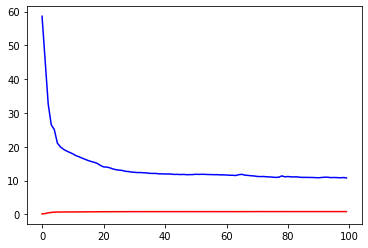

In [65]:
plt.plot(hist2.history['f1_perClass'], c='red')
plt.plot(hist2.history['loss'], c='blue')

In [ ]:
for i in range(len(lstm_tests)) :
    print( "==================HOME Case : %s =============" % test_names[i])
    lstm_pred= model2.predict( lstm_tests[i][0])
    
#     print_info( lstm_tests[i][1], lstm_pred, classes , confidance=0.7)
    print_info( lstm_tests[i][1], lstm_pred, classes , confidance=0.5)

In [ ]:
plt.plot(hist2.history['f1_perClass'], c='red')
plt.plot(hist2.history['loss'], c='blue')

In [ ]:
## Bidirectional LSTM :D 
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import TimeDistributed
from keras.layers import Bidirectional
from keras.layers import Flatten


import numpy as np
import os
import tensorflow as tf
from keras.models import Model

from keras.layers import Input, merge, concatenate, Conv2D, MaxPooling2D, Activation, UpSampling2D, Dropout, Conv2DTranspose, UpSampling2D, Lambda
from keras.layers import Dense, Dropout, Flatten
from keras.layers.normalization import BatchNormalization as bn
from keras.layers.merge import add
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras.optimizers import RMSprop
from keras import regularizers
from keras import backend as K
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.layers.merge import add
from keras.models import load_model
import numpy as np
from keras.regularizers import l2
from keras.layers import Conv1D
from keras.layers.merge import add
from keras.layers import Dense,Conv1D,Dropout,Activation,BatchNormalization,MaxPooling1D,Flatten,Masking,TimeDistributed
from keras.layers.recurrent import LSTM,GRU,SimpleRNN
from keras.models import Input,Sequential,Model
from keras.layers.merge import add
from keras.optimizers import Adam
from keras.losses import MSE,MSLE

model2 = Sequential()


def weighted_categorical_crossentropy(weights):
    """
    A weighted version of keras.objectives.categorical_crossentropy
    
    Variables:
        weights: numpy array of shape (C,) where C is the number of classes
    
    Usage:
        weights = np.array([0.5,2,10]) # Class one at 0.5, class 2 twice the normal weights, class 3 10x.
        loss = weighted_categorical_crossentropy(weights)
        model.compile(loss=loss,optimizer='adam')
    """
    
    weights = K.variable(weights)
        
    def loss(y_true, y_pred):
        # scale predictions so that the class probas of each sample sum to 1
        y_pred /= K.sum(y_pred, axis=-1, keepdims=True)
        # clip to prevent NaN's and Inf's
        y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
        # calc
        loss = y_true * K.log(y_pred) * weights
        loss = -K.sum(loss, -1)
        return loss
    
    return loss


import tensorflow as tf

def f1_perRow(y_true, y_pred):
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)


def f1_perClass(y_true, y_pred):

    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=1)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=1)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=1)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=1)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)

def f1_loss_perClass(y_true, y_pred):
    
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=1)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=1)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=1)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=1)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return (1 - K.mean(f1))**2

def f1_loss_perRow(y_true, y_pred):
    
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return (1 - K.mean(f1))**2



inputs  = Input( ( dim_size,1 ) )



# bi_d_1 = Bidirectional( LSTM(200 ,  recurrent_dropout=0.12, return_sequences=True),input_shape=[dim_size,1],merge_mode='concat') (inputs)
lstm_1 =  LSTM(100 ,  recurrent_dropout=0.04, return_sequences=True)(inputs)
# lstm_2 = LSTM(30 ,  recurrent_dropout=0.14, return_sequences=True)(lstm_1)

bi_d_1 =Dense(128, activation='relu')  (lstm_1)
lstm_1 =  Dense(128, activation='relu')(bi_d_1)
lstm_2 = Dense(128, activation='relu')(lstm_1)



# td_1    = TimeDistributed(Dense(256, activation='relu'))(lstm_2)
# dout_1  = Dropout(0.1)(td_1)
dout_1  = Dropout(0.1)(lstm_2)
flt_1   = Flatten()(dout_1)
dense_1 = Dense(128, activation='relu')(flt_1)
dout_2  = Dropout(0.2)(dense_1)







dens_out_3 = Dense( 128, activation='relu' )(dout_2)


# fl2  = Flatten()(out_new)

out_put_final = Dense(len(classes), activation='sigmoid', name='Event_output')(dens_out_3)

toService_1 = Dense( 130, name="to_service1" )(dens_out_3)
toService_1 = Dense( 130, name="to_service2" )(toService_1)

service_output = Dense(len(classes  ), activation="sigmoid", name = 'service_output')(toService_1)



model2 = Model(inputs=[inputs], outputs=[service_output])




# model2.add(Bidirectional( LSTM(200 ,  recurrent_dropout=0.12, return_sequences=True),input_shape=[dim_size,1],merge_mode='concat'))
# model2.add( LSTM(60 ,  recurrent_dropout=0.04, return_sequences=True))
# model2.add( LSTM(30 ,  recurrent_dropout=0.14, return_sequences=True))
# # model2.add(Bidirectional( LSTM(100 ,  recurrent_dropout=0.04, return_sequences=True),merge_mode='concat'))
# model2.add(TimeDistributed(Dense(256, activation='relu')))
# model2.add(Dropout(0.1))
# model2.add(Flatten())
# model2.add(Dense(128, activation='relu'))
# model2.add(Dropout(0.2))
# model2.add(Dense(len(classes), activation='sigmoid'))

# model2.compile(loss=weighted_categorical_crossentropy(weights=weights), optimizer='adam', metrics=['accuracy'])



losses = {
#     "service_output": f1_loss_perClass ,
    "service_output": f1_loss_perRow ,
    "service_output": "categorical_crossentropy",
}
lossWeights = {#"service_output": 20,
               "service_output": 30.0 ,
    "service_output": 20}
 


#model2.compile(loss=losses,loss_weights=lossWeights, optimizer='adam', metrics=[f1_perRow,f1_perClass,'acc'])
model2.compile(loss=losses, loss_weights=lossWeights, optimizer='adam', metrics=['accuracy'])

checkpoint = ModelCheckpoint('IoTDownNet', monitor='loss', verbose=0, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

print(model2.summary())
hist2 = model2.fit(x_lstm_prossed_train2, y_lstm_prossed_train, epochs=1000, batch_size=12500, shuffle=True, callbacks=callbacks_list)





In [ ]:
## Bidirectional LSTM :D 
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import TimeDistributed
from keras.layers import Bidirectional
from keras.layers import Flatten


import numpy as np
import os
import tensorflow as tf
from keras.models import Model

from keras.layers import Input, merge, concatenate, Conv2D, MaxPooling2D, Activation, UpSampling2D, Dropout, Conv2DTranspose, UpSampling2D, Lambda
from keras.layers import Dense, Dropout, Flatten
from keras.layers.normalization import BatchNormalization as bn
from keras.layers.merge import add
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras.optimizers import RMSprop
from keras import regularizers
from keras import backend as K
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.layers.merge import add
from keras.models import load_model
import numpy as np
from keras.regularizers import l2
from keras.layers import Conv1D
from keras.layers.merge import add
from keras.layers import Dense,Conv1D,Dropout,Activation,BatchNormalization,MaxPooling1D,Flatten,Masking,TimeDistributed
from keras.layers.recurrent import LSTM,GRU,SimpleRNN
from keras.models import Input,Sequential,Model
from keras.layers.merge import add
from keras.optimizers import Adam
from keras.losses import MSE,MSLE

model2 = Sequential()


def weighted_categorical_crossentropy(weights):
    """
    A weighted version of keras.objectives.categorical_crossentropy
    
    Variables:
        weights: numpy array of shape (C,) where C is the number of classes
    
    Usage:
        weights = np.array([0.5,2,10]) # Class one at 0.5, class 2 twice the normal weights, class 3 10x.
        loss = weighted_categorical_crossentropy(weights)
        model.compile(loss=loss,optimizer='adam')
    """
    
    weights = K.variable(weights)
        
    def loss(y_true, y_pred):
        # scale predictions so that the class probas of each sample sum to 1
        y_pred /= K.sum(y_pred, axis=-1, keepdims=True)
        # clip to prevent NaN's and Inf's
        y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
        # calc
        loss = y_true * K.log(y_pred) * weights
        loss = -K.sum(loss, -1)
        return loss
    
    return loss


import tensorflow as tf

def f1_perRow(y_true, y_pred):
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)


def f1_perClass(y_true, y_pred):

    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=1)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=1)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=1)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=1)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)

def f1_loss_perClass(y_true, y_pred):
    
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=1)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=1)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=1)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=1)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return (1 - K.mean(f1))**2

def f1_loss_perRow(y_true, y_pred):
    
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return (1 - K.mean(f1))**2



inputs  = Input( ( dim_size,1 ) )






out = Conv1D(128,3,padding='same')(inputs)
out = BatchNormalization()(out)
out = Activation('relu')(out)
out = Dropout(0.2)(out)
out = Conv1D(128,3,padding='same')(out)
# out = Flatten()(out)
# out = MaxPooling1D(2,padding='same', name ='pooling')(out)


out = Conv1D(128,3,padding='same')(out)
out = BatchNormalization()(out)
out = Activation('relu')(out)
out = Dropout(0.2)(out)
out = Conv1D(128,3,padding='same')(out)
# out = Flatten()(out)
# out = MaxPooling1D(2,padding='same', name ='pooling2')(out)


out = Conv1D(128,3,padding='same')(out)
out = BatchNormalization()(out)
out = Activation('relu')(out)
out = Dropout(0.2)(out)
out = Conv1D(128,3,padding='same')(out)
# out = Flatten()(out)
# out = MaxPooling1D(2,padding='same', name ='pooling')(out)



# fl_out_1 = Flatten()(dout_2)

fl_out_cnn = Flatten()(out)


dens_out_3 = Dense( 128, activation='relu' )(fl_out_cnn)

# fl2  = Flatten()(out_new)

out_put_final = Dense(len(classes), activation='sigmoid', name='Event_output')(dens_out_3)

toService_1 = Dense( 130, name="to_service1" )(dens_out_3)
toService_1 = Dense( 130, name="to_service2" )(toService_1)

service_output = Dense(len(classes  ), activation="sigmoid", name = 'service_output')(toService_1)



model2 = Model(inputs=[inputs], outputs=[service_output])




# model2.add(Bidirectional( LSTM(200 ,  recurrent_dropout=0.12, return_sequences=True),input_shape=[dim_size,1],merge_mode='concat'))
# model2.add( LSTM(60 ,  recurrent_dropout=0.04, return_sequences=True))
# model2.add( LSTM(30 ,  recurrent_dropout=0.14, return_sequences=True))
# # model2.add(Bidirectional( LSTM(100 ,  recurrent_dropout=0.04, return_sequences=True),merge_mode='concat'))
# model2.add(TimeDistributed(Dense(256, activation='relu')))
# model2.add(Dropout(0.1))
# model2.add(Flatten())
# model2.add(Dense(128, activation='relu'))
# model2.add(Dropout(0.2))
# model2.add(Dense(len(classes), activation='sigmoid'))

# model2.compile(loss=weighted_categorical_crossentropy(weights=weights), optimizer='adam', metrics=['accuracy'])



losses = {
#     "service_output": f1_loss_perClass ,
    "service_output": f1_loss_perRow ,
    "service_output": "categorical_crossentropy",
}
lossWeights = {#"service_output": 20,
               "service_output": 30.0 ,
    "service_output": 20}
 


model2.compile(loss=losses,loss_weights=lossWeights, optimizer='adam', metrics=[f1_perRow,f1_perClass,'acc'])
# model2.compile(loss=losses, loss_weights=lossWeights, optimizer='adam', metrics=['accuracy'])

checkpoint = ModelCheckpoint('IoTDownNet', monitor='loss', verbose=0, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

print(model2.summary())
hist2 = model2.fit(x_lstm_prossed_train2, y_lstm_prossed_train, epochs=100, batch_size=12500, shuffle=True, callbacks=callbacks_list)





In [ ]:
## Bidirectional LSTM :D 
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import TimeDistributed
from keras.layers import Bidirectional
from keras.layers import Flatten


import numpy as np
import os
import tensorflow as tf
from keras.models import Model

from keras.layers import Input, merge, concatenate, Conv2D, MaxPooling2D, Activation, UpSampling2D, Dropout, Conv2DTranspose, UpSampling2D, Lambda
from keras.layers import Dense, Dropout, Flatten
from keras.layers.normalization import BatchNormalization as bn
from keras.layers.merge import add
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras.optimizers import RMSprop
from keras import regularizers
from keras import backend as K
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.layers.merge import add
from keras.models import load_model
import numpy as np
from keras.regularizers import l2
from keras.layers import Conv1D
from keras.layers.merge import add
from keras.layers import Dense,Conv1D,Dropout,Activation,BatchNormalization,MaxPooling1D,Flatten,Masking,TimeDistributed
from keras.layers.recurrent import LSTM,GRU,SimpleRNN
from keras.models import Input,Sequential,Model
from keras.layers.merge import add
from keras.optimizers import Adam
from keras.losses import MSE,MSLE

model2 = Sequential()


def weighted_categorical_crossentropy(weights):
    """
    A weighted version of keras.objectives.categorical_crossentropy
    
    Variables:
        weights: numpy array of shape (C,) where C is the number of classes
    
    Usage:
        weights = np.array([0.5,2,10]) # Class one at 0.5, class 2 twice the normal weights, class 3 10x.
        loss = weighted_categorical_crossentropy(weights)
        model.compile(loss=loss,optimizer='adam')
    """
    
    weights = K.variable(weights)
        
    def loss(y_true, y_pred):
        # scale predictions so that the class probas of each sample sum to 1
        y_pred /= K.sum(y_pred, axis=-1, keepdims=True)
        # clip to prevent NaN's and Inf's
        y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
        # calc
        loss = y_true * K.log(y_pred) * weights
        loss = -K.sum(loss, -1)
        return loss
    
    return loss


import tensorflow as tf

def f1_perRow(y_true, y_pred):
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)


def f1_perClass(y_true, y_pred):

    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=1)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=1)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=1)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=1)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)

def f1_loss_perClass(y_true, y_pred):
    
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=1)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=1)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=1)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=1)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return (1 - K.mean(f1)) 

def f1_loss_perRow(y_true, y_pred):
    
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return (1 - K.mean(f1))



inputs  = Input( ( dim_size,1 ) )







# bi_d_1 = Bidirectional( LSTM(200 ,  recurrent_dropout=0.12, return_sequences=True),input_shape=[dim_size,1],merge_mode='concat') (inputs)
lstm_1 =  LSTM(100 ,  recurrent_dropout=0.04, return_sequences=True)(inputs)
# lstm_1 = LSTM(40 ,  recurrent_dropout=0.14, return_sequences=True)(lstm_1)

bi_d_raw_1 =Dense(128, activation='relu')  (lstm_1)
lstm_raw_1 =  Dense(128, activation='relu')(bi_d_raw_1)
lstm_raw_2 = Dense(128, activation='relu')(lstm_raw_1)

dout_1  = Dropout(0.1)(lstm_raw_2)
flt_1   = Flatten()(dout_1)
dense_1 = Dense(128, activation='relu')(flt_1)
dout_3  = Dropout(0.2)(dense_1)





out = Conv1D(128,3,padding='same')(inputs)
out = BatchNormalization()(out)
out = Activation('relu')(out)
out = Dropout(0.2)(out)
out = Conv1D(128,3,padding='same')(out)
# out = Flatten()(out)
# out = MaxPooling1D(2,padding='same', name ='pooling')(out)


out = Conv1D(128,3,padding='same')(out)
out = BatchNormalization()(out)
out = Activation('relu')(out)
out = Dropout(0.2)(out)
out = Conv1D(128,3,padding='same')(out)
# out = Flatten()(out)
# out = MaxPooling1D(2,padding='same', name ='pooling2')(out)


out = Conv1D(128,3,padding='same')(out)
out = BatchNormalization()(out)
out = Activation('relu')(out)
out = Dropout(0.2)(out)
out = Conv1D(128,3,padding='same')(out)
# out = Flatten()(out)
# out = MaxPooling1D(2,padding='same', name ='pooling')(out)



# fl_out_1 = Flatten()(dout_2)

fl_out_cnn = Flatten()(out)

# out_new = concatenate( [fl_out_1, fl_out_cnn] , name='mergerguy')
out_new = concatenate( [ fl_out_cnn,dout_3] , name='mergerguy')

dens_out_1 = Dense( 128, activation='relu' )(out_new)
dens_out_2 = Dense( 128, activation='relu' )(dens_out_1)
dens_out_3 = Dense( 128, activation='relu' )(dens_out_2)



service_output = Dense(len(classes  ), activation="sigmoid", name = 'service_output')(dens_out_3)



model2 = Model(inputs=[inputs], outputs=[service_output])




# model2.add(Bidirectional( LSTM(200 ,  recurrent_dropout=0.12, return_sequences=True),input_shape=[dim_size,1],merge_mode='concat'))
# model2.add( LSTM(60 ,  recurrent_dropout=0.04, return_sequences=True))
# model2.add( LSTM(30 ,  recurrent_dropout=0.14, return_sequences=True))
# # model2.add(Bidirectional( LSTM(100 ,  recurrent_dropout=0.04, return_sequences=True),merge_mode='concat'))
# model2.add(TimeDistributed(Dense(256, activation='relu')))
# model2.add(Dropout(0.1))
# model2.add(Flatten())
# model2.add(Dense(128, activation='relu'))
# model2.add(Dropout(0.2))
# model2.add(Dense(len(classes), activation='sigmoid'))

# model2.compile(loss=weighted_categorical_crossentropy(weights=weights), optimizer='adam', metrics=['accuracy'])



losses = {
#     "service_output": f1_loss_perClass ,
    "service_output": f1_loss_perRow ,
    "service_output": "categorical_crossentropy",
}
lossWeights = {#"service_output": 20,
               "service_output": 30.0 ,
    "service_output": 20}
 


model2.compile(loss=losses,loss_weights=lossWeights, optimizer='adam', metrics=[f1_perRow,f1_perClass,'acc'])
# model2.compile(loss=losses, loss_weights=lossWeights, optimizer='adam', metrics=['accuracy'])

checkpoint = ModelCheckpoint('IoTDownNet', monitor='loss', verbose=0, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

print(model2.summary())
hist2 = model2.fit(x_lstm_prossed_train2, y_lstm_prossed_train, epochs=100, batch_size=12500, shuffle=True, callbacks=callbacks_list)





In [ ]:
losses = {
#     "service_output": f1_loss_perClass ,
    "service_output": f1_loss_perClass ,
#     "service_output": "categorical_crossentropy",
}
lossWeights = {#"service_output": 20,
               "service_output": 30.0 ,
#     "service_output": 20
}
 


model2.compile(loss=losses, loss_weights=lossWeights, optimizer=keras.optimizers.Adam(lr=1e-6  ), metrics=[f1_perRow,f1_perClass,'acc'])


In [ ]:
## Bidirectional LSTM :D 
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import TimeDistributed
from keras.layers import Bidirectional
from keras.layers import Flatten


import numpy as np
import os
import tensorflow as tf
from keras.models import Model

from keras.layers import Input, merge, concatenate, Conv2D, MaxPooling2D, Activation, UpSampling2D, Dropout, Conv2DTranspose, UpSampling2D, Lambda
from keras.layers import Dense, Dropout, Flatten
from keras.layers.normalization import BatchNormalization as bn
from keras.layers.merge import add
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras.optimizers import RMSprop
from keras import regularizers
from keras import backend as K
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.layers.merge import add
from keras.models import load_model
import numpy as np
from keras.regularizers import l2
from keras.layers import Conv1D
from keras.layers.merge import add
from keras.layers import Dense,Conv1D,Dropout,Activation,BatchNormalization,MaxPooling1D,Flatten,Masking,TimeDistributed
from keras.layers.recurrent import LSTM,GRU,SimpleRNN
from keras.models import Input,Sequential,Model
from keras.layers.merge import add
from keras.optimizers import Adam
from keras.losses import MSE,MSLE

model2 = Sequential()


def weighted_categorical_crossentropy(weights):
    """
    A weighted version of keras.objectives.categorical_crossentropy
    
    Variables:
        weights: numpy array of shape (C,) where C is the number of classes
    
    Usage:
        weights = np.array([0.5,2,10]) # Class one at 0.5, class 2 twice the normal weights, class 3 10x.
        loss = weighted_categorical_crossentropy(weights)
        model.compile(loss=loss,optimizer='adam')
    """
    
    weights = K.variable(weights)
        
    def loss(y_true, y_pred):
        # scale predictions so that the class probas of each sample sum to 1
        y_pred /= K.sum(y_pred, axis=-1, keepdims=True)
        # clip to prevent NaN's and Inf's
        y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
        # calc
        loss = y_true * K.log(y_pred) * weights
        loss = -K.sum(loss, -1)
        return loss
    
    return loss


import tensorflow as tf

def f1_perRow(y_true, y_pred):
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)


def f1_perClass(y_true, y_pred):

    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=1)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=1)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=1)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=1)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)

def f1_loss_perClass(y_true, y_pred):
    
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=1)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=1)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=1)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=1)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return (1 - K.mean(f1))**2

def f1_loss_perRow(y_true, y_pred):
    
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return (1 - K.mean(f1))**2



inputs  = Input( ( dim_size,1 ) )



# bi_d_1 = Bidirectional( LSTM(200 ,  recurrent_dropout=0.12, return_sequences=True),input_shape=[dim_size,1],merge_mode='concat') (inputs)
lstm_1 =  LSTM(32 ,  recurrent_dropout=0.3, return_sequences=True)(inputs)
lstm_2 = LSTM(32 ,  recurrent_dropout=0.3, return_sequences=True)(lstm_1)

lstm_2=Flatten()(lstm_2)
lstm_2 = Dense(256, activation='relu')(lstm_2)




service_output = Dense(len(classes  ), activation="sigmoid", name = 'service_output')(lstm_2)



model2 = Model(inputs=[inputs], outputs=[service_output])




# model2.add(Bidirectional( LSTM(200 ,  recurrent_dropout=0.12, return_sequences=True),input_shape=[dim_size,1],merge_mode='concat'))
# model2.add( LSTM(60 ,  recurrent_dropout=0.04, return_sequences=True))
# model2.add( LSTM(30 ,  recurrent_dropout=0.14, return_sequences=True))
# # model2.add(Bidirectional( LSTM(100 ,  recurrent_dropout=0.04, return_sequences=True),merge_mode='concat'))
# model2.add(TimeDistributed(Dense(256, activation='relu')))
# model2.add(Dropout(0.1))
# model2.add(Flatten())
# model2.add(Dense(128, activation='relu'))
# model2.add(Dropout(0.2))
# model2.add(Dense(len(classes), activation='sigmoid'))

# model2.compile(loss=weighted_categorical_crossentropy(weights=weights), optimizer='adam', metrics=['accuracy'])



losses = {
#     "service_output": f1_loss_perClass ,
    "service_output": f1_loss_perRow ,
    "service_output": "categorical_crossentropy",
}
lossWeights = {#"service_output": 20,
               "service_output": 30.0 ,
    "service_output": 20}
 


model2.compile(loss=losses,loss_weights=lossWeights, optimizer='adam', metrics=[f1_perRow,f1_perClass,'acc'])
# model2.compile(loss=losses, loss_weights=lossWeights, optimizer='adam', metrics=['accuracy'])

checkpoint = ModelCheckpoint('IoTDownNet', monitor='loss', verbose=0, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

print(model2.summary())

hist2 = model2.fit(x_lstm_prossed_train2, y_lstm_prossed_train, epochs=100, batch_size=12500, shuffle=True, callbacks=callbacks_list)



In [ ]:
#split model
## Bidirectional LSTM :D 
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import TimeDistributed
from keras.layers import Bidirectional
from keras.layers import Flatten


import numpy as np
import os
import tensorflow as tf
from keras.models import Model

from keras.layers import Input, merge, concatenate, Conv2D, MaxPooling2D, Activation, UpSampling2D, Dropout, Conv2DTranspose, UpSampling2D, Lambda
from keras.layers import Dense, Dropout, Flatten
from keras.layers.normalization import BatchNormalization as bn
from keras.layers.merge import add
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras.optimizers import RMSprop
from keras import regularizers
from keras import backend as K
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.layers.merge import add
from keras.models import load_model
import numpy as np
from keras.regularizers import l2
from keras.layers import Conv1D
from keras.layers.merge import add
from keras.layers import Dense,Conv1D,Dropout,Activation,BatchNormalization,MaxPooling1D,Flatten,Masking,TimeDistributed
from keras.layers.recurrent import LSTM,GRU,SimpleRNN
from keras.models import Input,Sequential,Model
from keras.layers.merge import add
from keras.optimizers import Adam
from keras.losses import MSE,MSLE

model2 = Sequential()


def weighted_categorical_crossentropy(weights):
    """
    A weighted version of keras.objectives.categorical_crossentropy
    
    Variables:
        weights: numpy array of shape (C,) where C is the number of classes
    
    Usage:
        weights = np.array([0.5,2,10]) # Class one at 0.5, class 2 twice the normal weights, class 3 10x.
        loss = weighted_categorical_crossentropy(weights)
        model.compile(loss=loss,optimizer='adam')
    """
    
    weights = K.variable(weights)
        
    def loss(y_true, y_pred):
        # scale predictions so that the class probas of each sample sum to 1
        y_pred /= K.sum(y_pred, axis=-1, keepdims=True)
        # clip to prevent NaN's and Inf's
        y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
        # calc
        loss = y_true * K.log(y_pred) * weights
        loss = -K.sum(loss, -1)
        return loss
    
    return loss


import tensorflow as tf

def f1_perRow(y_true, y_pred):
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)


def f1_perClass(y_true, y_pred):

    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=1)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=1)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=1)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=1)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)

def f1_loss_perClass(y_true, y_pred):
    
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=1)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=1)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=1)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=1)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return (1 - K.mean(f1))**2

def f1_loss_perRow(y_true, y_pred):
    
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return (1 - K.mean(f1))**2

#splitting data
X=x_lstm_prossed_train2
y=y_lstm_prossed_train
a,b,c,d,e,f,g,h,ii,jj,k,l,m,n,o,p=[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[]
print(len(y_lstm_prossed_train[0]))
for i in range(0,len(y_lstm_prossed_train)):
    a.append(y_lstm_prossed_train[i][0])
    b.append(y_lstm_prossed_train[i][1])
    c.append(y_lstm_prossed_train[i][2])
    d.append(y_lstm_prossed_train[i][3])
    e.append(y_lstm_prossed_train[i][4])
    f.append(y_lstm_prossed_train[i][5])
    g.append(y_lstm_prossed_train[i][6])
    h.append(y_lstm_prossed_train[i][7])
    ii.append(y_lstm_prossed_train[i][8])
    jj.append(y_lstm_prossed_train[i][9])
    k.append(y_lstm_prossed_train[i][10])
    l.append(y_lstm_prossed_train[i][11])
    m.append(y_lstm_prossed_train[i][12])
    n.append(y_lstm_prossed_train[i][13])
    o.append(y_lstm_prossed_train[i][14])
    p.append(y_lstm_prossed_train[i][15])
    
zzzz=[]    
zzzz.append(np.array(a))
zzzz.append(np.array(b))
zzzz.append(np.array(c))
zzzz.append(np.array(d))
zzzz.append(np.array(e))
zzzz.append(np.array(f))
zzzz.append(np.array(g))
zzzz.append(np.array(h))
zzzz.append(np.array(ii))
zzzz.append(np.array(jj))
zzzz.append(np.array(k))
zzzz.append(np.array(l))
zzzz.append(np.array(m))
zzzz.append(np.array(n))
zzzz.append(np.array(o))
zzzz.append(np.array(p))


for i in range(0,16):
    
    
        
        
    


    inputs  = Input( ( dim_size,1 ) )


    out = Conv1D(128,3,padding='same')(inputs)
    out = BatchNormalization()(out)
    out = Activation('relu')(out)
    out = Dropout(0.2)(out)
    out = Conv1D(128,3,padding='same')(out)
    # bi_d_1 = Bidirectional( LSTM(200 ,  recurrent_dropout=0.12, return_sequences=True),input_shape=[dim_size,1],merge_mode='concat') (inputs)
    lstm_1 =  LSTM(100 ,  recurrent_dropout=0.04, return_sequences=True)(out)
    # lstm_2 = LSTM(30 ,  recurrent_dropout=0.14, return_sequences=True)(lstm_1)

    bi_d_1 =Dense(128, activation='relu')  (lstm_1)
    lstm_1 =  Dense(128, activation='relu')(bi_d_1)
    lstm_2 = Dense(128, activation='relu')(lstm_1)



    # td_1    = TimeDistributed(Dense(256, activation='relu'))(lstm_2)
    # dout_1  = Dropout(0.1)(td_1)
    dout_1  = Dropout(0.1)(lstm_2)
    flt_1   = Flatten()(dout_1)
    dense_1 = Dense(128, activation='relu')(flt_1)
    dout_2  = Dropout(0.2)(dense_1)





    # bi_d_1 = Bidirectional( LSTM(200 ,  recurrent_dropout=0.12, return_sequences=True),input_shape=[dim_size,1],merge_mode='concat') (inputs)
    lstm_1 =  LSTM(100 ,  recurrent_dropout=0.04, return_sequences=True)(inputs)
    # lstm_1 = LSTM(40 ,  recurrent_dropout=0.14, return_sequences=True)(lstm_1)

    bi_d_raw_1 =Dense(128, activation='relu')  (lstm_1)
    lstm_raw_1 =  Dense(128, activation='relu')(bi_d_raw_1)
    lstm_raw_2 = Dense(128, activation='relu')(lstm_raw_1)

    dout_1  = Dropout(0.1)(lstm_raw_2)
    flt_1   = Flatten()(dout_1)
    dense_1 = Dense(128, activation='relu')(flt_1)
    dout_3  = Dropout(0.2)(dense_1)





    out = Conv1D(128,3,padding='same')(inputs)
    out = BatchNormalization()(out)
    out = Activation('relu')(out)
    out = Dropout(0.2)(out)
    out = Conv1D(128,3,padding='same')(out)
    # out = Flatten()(out)
    # out = MaxPooling1D(2,padding='same', name ='pooling')(out)


    out = Conv1D(128,3,padding='same')(out)
    out = BatchNormalization()(out)
    out = Activation('relu')(out)
    out = Dropout(0.2)(out)
    out = Conv1D(128,3,padding='same')(out)
    # out = Flatten()(out)
    # out = MaxPooling1D(2,padding='same', name ='pooling2')(out)


    out = Conv1D(128,3,padding='same')(out)
    out = BatchNormalization()(out)
    out = Activation('relu')(out)
    out = Dropout(0.2)(out)
    out = Conv1D(128,3,padding='same')(out)
    # out = Flatten()(out)
    # out = MaxPooling1D(2,padding='same', name ='pooling')(out)



    # fl_out_1 = Flatten()(dout_2)

    fl_out_cnn = Flatten()(out)

    # out_new = concatenate( [fl_out_1, fl_out_cnn] , name='mergerguy')
    out_new = concatenate( [dout_2, fl_out_cnn,dout_3] , name='mergerguy')

    dens_out_1 = Dense( 128, activation='relu' )(out_new)
    dens_out_2 = Dense( 128, activation='relu' )(dens_out_1)
    dens_out_3 = Dense( 128, activation='relu' )(dens_out_2)

    # fl2  = Flatten()(out_new)

    out_put_final = Dense(len(classes), activation='sigmoid', name='Event_output')(dens_out_3)

    toService_1 = Dense( 130, name="to_service1" )(dens_out_3)
    toService_1 = Dense( 130, name="to_service2" )(toService_1)

    service_output = Dense(1, activation="sigmoid", name = 'service_output')(toService_1)


    losses = {
    #     "service_output": f1_loss_perClass ,
        "service_output": f1_loss_perRow ,
        "service_output": "binary_crossentropy",
    }
    lossWeights = {#"service_output": 20,
                   "service_output": 30.0 ,
        "service_output": 20}




    model2 = Model(inputs=[inputs], outputs=[service_output])
    model2.compile(loss=losses,loss_weights=lossWeights, optimizer='adam', metrics=[f1_perRow,f1_perClass,'acc'])
    # model2.compile(loss=losses, loss_weights=lossWeights, optimizer='adam', metrics=['accuracy'])

    checkpoint = ModelCheckpoint('IoTDownNet', monitor='loss', verbose=0, save_best_only=True, mode='min')
    callbacks_list = [checkpoint]
    hist2 = model2.fit(x_lstm_prossed_train2, zzzz[i], epochs=200, batch_size=12500, shuffle=True, callbacks=callbacks_list)
    model2.save('number'+str(i)+'.h5')


In [ ]:
# model2.compile(loss=losses,loss_weights=lossWeights, optimizer=keras.optimizers.Adam(lr=5e-5  ), metrics=[f1_perRow,f1_perClass,'acc'])
hist2 = model2.fit(x_lstm_prossed_train2, y_lstm_prossed_train, epochs=300, batch_size=16500, shuffle=True)


In [ ]:
model2.compile(loss=f1_loss, optimizer=keras.optimizers.Adam(lr=8e-5  ), metrics=[f1,'acc'])
hist2 = model2.fit(x_lstm_prossed_train2, y_lstm_prossed_train, epochs=300, batch_size=7500, shuffle=True)

In [ ]:
model2.compile(loss=weighted_categorical_crossentropy(weights=weights), optimizer=keras.optimizers.Adam(lr=8e-5  ), metrics=['accuracy'])

In [ ]:
model2.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(lr=8e-5  ), metrics=['accuracy'])

In [ ]:
model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
model2.compile(loss=weighted_categorical_crossentropy(weights=weights), optimizer='adam', metrics=['accuracy'])

In [ ]:
hist2 = model2.fit(x_lstm_prossed_train2, y_lstm_prossed_train, epochs=300, batch_size=3500, shuffle=True)

In [ ]:
model2.save( "LSTM-sigmoid-withRemovedClasses" )

In [ ]:
plt.plot(hist2.history['loss'], c='red')
plt.plot(hist2.history['acc'], c='blue')

In [ ]:
plt.plot(hist2.history['loss'], c='red')
# plt.plot(hist2.history['acc'], c='blue')

In [ ]:
from keras.utils import plot_model
plot_model(model2, to_file='model.png')

In [ ]:
# from keras.models import load_model
# model2=load_model( "LSTM_withSigmoid_LargeData_F1_E100_B500_MSE_False"  
#            )

In [ ]:
for i in range(len(lstm_tests)) :
    print( "==================HOME Case : %s =============" % test_names[i])
    makeReadable( classes=classes, confidance=0.5,data=lstm_tests[i][0],gt=lstm_tests[i][1],model=model2,path=test_names[i],x=lstm_tests[i][0])
    
#     lstm_pred= model2.predict( lstm_tests[i][0])
    


# ------------- do not go any further :) ------

In [ ]:
lstm_pred= model2.predict( lstm_tests[i][0])

In [ ]:
lstm_pred= model2.predict( lstm_tests[1][0])
lstm_pred__ = np.array(list(lstm_pred))

In [ ]:
lstm_pred__ = np.array(list(lstm_pred))
print_info( lstm_tests[1][1], lstm_pred__, classes , confidance=0.43)

In [ ]:
# for i in [1] :
for i in range(len(lstm_tests)) :
    print( "==================HOME Case : %s =============" % test_names[i])
    lstm_pred= model2.predict( lstm_tests[i][0])
    
#     print_info( lstm_tests[i][1], lstm_pred, classes , confidance=0.7)
    print_info( lstm_tests[i][1], lstm_pred, classes , confidance=0.5)
    

In [ ]:
for i in [1] :
# for i in range(len(lstm_tests)) :
    print( "==================HOME Case : %s =============" % test_names[i])
    lstm_pred= model2.predict( lstm_tests[i][0])
    
#     print_info( lstm_tests[i][1], lstm_pred, classes , confidance=0.7)
    print_info( lstm_tests[i][1], lstm_pred, classes , confidance=0.992)
    



In [ ]:
lstm_pred =model2.predict( x_lstm_prossed_test2)


In [ ]:
print_info(y_lstm_prossed_test, lstm_pred, classes, confidance=0.60)

In [ ]:
lstm_pred =model2.predict( x_lstm_prossed_test)
print_info(y_lstm_prossed_test, lstm_pred, classes, confidance=0.6)

In [ ]:
lstm_pred = model2.predict( x_lstm_prossed_test)
print_info(y_lstm_prossed_test, lstm_pred, classes, confidance=0.6)

In [ ]:
print_info(y_lstm_prossed_train, y_lstm_prossed_train, classes, confidance=0.60)

In [ ]:
[x for x  in lstm_pred  if  np.sum(x) > 0 ]

In [ ]:
model2.save( "LSTM_withSigmoid_LargeData_F%s_E%d_B%d_M%s_%r" %
            (
            FoldID,
                Epoch_count,
                Batch_size,
                Mapper,
                IgnoreEmpty
            ) 
           )

In [ ]:
lstm_pred = model2.predict( x_lstm_prossed_test )

In [ ]:
print_info(y_lstm_prossed_test, lstm_pred, classes)

In [ ]:
# x_train_muhammed,y_train_muhammed, classes = pre_process_raw( x_train, y_train , dim_size, zero_pad=True, normalize=False)
# x_test_muhammed,y_test_muhammed, classes = pre_process_raw( x_test, y_test , dim_size, zero_pad=True, normalize=False)

In [ ]:
lstm_pred = model2.predict( x_lstm_prossed_test )
print_info(y_lstm_prossed_test, lstm_pred, classes)

In [ ]:
lstm_pred = model2.predict( x_lstm_prossed_test )
print_info(y_lstm_prossed_test, lstm_pred, classes)

In [ ]:
pred[:10]

In [ ]:
print_info(y_lstm_prossed_test, pred, classes)

In [ ]:
pred[0]

In [ ]:
len( y_lstm_prossed_train[0] )

In [ ]:
dim_size =160
x_lstm_prossed_train,y_lstm_prossed_train, _ = pre_process_raw( x_train, y_train , dim_size, zero_pad=True, normalize=False,classes=classes)
x_lstm_prossed_test,y_lstm_prossed_test, _ = pre_process_raw( x_test, y_test , dim_size, zero_pad=True, , class_cap=TEST_CLASS_CAPnormalize=False,classes=classes)

In [ ]:
len([x  for x  in y_lstm_prossed_test if x[21]==1 or x[20]==1]), len(y_lstm_prossed_test  ) , len([x  for x  in y_lstm_prossed_test if x[21]==1 or x[20]==1])/len(y_lstm_prossed_test  ) *1.0

In [ ]:
[ x for x  in  pred if np.sum(x) > 1]

In [ ]:
len(y_lstm_prossed_test)

In [ ]:
def do_for_raun( pred   ):
    pp = pred
    pp[pp>=0.5] = 1
    pp[pp<0.5] = 0
    return pp

In [ ]:
len([x for x in pred if np.sum( do_for_raun(x) )==0 ])

In [ ]:
len([x for x in pred if  do_for_raun(x)[20] ==1 or do_for_raun(x)[21] ==1 ])

In [ ]:

# np.save("../files/muhammed/x_train.json" , x_train_muhammed)
# np.save("../files/muhammed/y_train.json", )


# np.save( "../files/muhammed/x_train.json", x_train_muhammed )
# np.save("../files/muhammed/y_train.json",  y_train_muhammed )
# np.save( "../files/muhammed/x_test.json",x_test_muhammed )
# np.save( "../files/muhammed/y_test.json",y_test_muhammed )
# np.save( "../files/muhammed/classes.json",  classes )


In [ ]:
len(x_lstm_prossed_test) + len(x_lstm_prossed_train)